<a href="https://colab.research.google.com/github/RonChits/Default-Probability/blob/main/Default_Probality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data importing.

>Modules to be used.

In [ ]:
import pandas as pd
import numpy as np
import re
import nest_asyncio
import xgboost
# import uvicorn
# import category_encoders as ce
# import seaborn as sns
# import nominatim
import geopy
import string
import pickle
import requests
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
# sampling techniques.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# classifiers.
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# transformers.
from sklearn.preprocessing import StandardScaler,  OneHotEncoder, LabelEncoder, FunctionTransformer

# metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay,precision_score, f1_score, roc_curve , auc, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline

#http communications.
# from fastapi import FastAPI , Body, HTTPException, Request, status
# from fastapi.encoders import jsonable_encoder
# from fastapi.exceptions import RequestValidationError
# from fastapi.responses import JSONResponse

# extras.
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pydantic import BaseModel
from tabulate import tabulate
import dill
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization

### Assigning to dataframe csv to df.

---



In [ ]:
df = pd.read_csv("data_science_competition_2024.csv", index_col=0)

.

---
>Gaining a basic understanding of the structure and content of our dataframe, which is essential for further data exploration and analysis.

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_id               100000 non-null  object 
 1   gender                100000 non-null  object 
 2   disbursemet_date      100000 non-null  object 
 3   currency              100000 non-null  object 
 4   country               99900 non-null   object 
 5   sex                   100000 non-null  object 
 6   is_employed           100000 non-null  bool   
 7   job                   95864 non-null   object 
 8   location              99405 non-null   object 
 9   loan_amount           100000 non-null  float64
 10  number_of_defaults    100000 non-null  int64  
 11  outstanding_balance   100000 non-null  float64
 12  interest_rate         100000 non-null  float64
 13  age                   100000 non-null  int64  
 14  number_of_defaults.1  100000 non-null  int64  
 15  remain

(100000, 20)

In [ ]:
df.head(5)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default


#### Cleaning of the data with aspects observed(a comprehensive/shorter way).



> Summarry of data Cleaning of dataframe of loans



In [ ]:
# Summarry of data Cleaning of dataframe of loans
def wrangle(df):
    def clean_currency(value):
        return re.sub(r'\$', '', value)
    def empty_strings(series):
        return series.replace(r'^\s*$', 'other', regex = True)

    df['currency'] = df['currency'].astype(str)
    df['marital_status'] = df['marital_status'].astype(str)
        #cleaning dollar sign on currency
    df['currency'] = df['currency'].apply(clean_currency)

        #cleaning empty strings on marital status
    df['marital_status'] = empty_strings(df['marital_status'])
        # Droping the duplicates rowwise
    df=df.drop_duplicates()

        #Droping null values
    df=df.dropna(how='any')


    df= df.rename(columns={"remaining term" : "remaining_term"})
    df= df.rename(columns={"Loan Status" : "Loan_Status"})

        # Using Pandas to change their datatypes
    df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'],
                                              format ='%Y %m %d')
    df['remaining_term']= pd.to_numeric(df['remaining_term'], errors= 'coerce')

        #removing outliers
        # remaining term
    df = df[df["remaining_term"]<80]


        # outlier ...interest rate--
    i1, i9 = df["interest_rate"].quantile([0.01, 0.99])
    mask = df["interest_rate"].between(i1, i9)
    df = df[mask]

        # outlier ...loan amount--
        #l1, l9 = df["loan_amount"].quantile([0.05, 0.95])
        #mask2 = df["loan_amount"].between(l1, l9)
        #df = df[mask2]

        # outlier ...outstanding balance--
        #o1, o9 = df["outstanding_balance"].quantile([0.05, 0.95])
        #mask3 = df["outstanding_balance"].between(o1, o9)
        #df = df[mask3]

        # outlier ...age--
        #a1, a9 = df["age"].quantile([0.05, 0.95])
        #mask4 = df["age"].between(a1, a9)
        #df = df[mask4]

        #lets drop the columns that are duplicated
        #Droping sex , number_of_defaults.1 and age.1
    columns_to_drop =['sex', 'number_of_defaults.1', 'age.1']
    df =df.drop(columns_to_drop, axis=1)

    return df

With wrangle function im cleaning the df at once with observed issues on data exploration.

In [ ]:
df = wrangle(df)

# EDA

> More information about df.

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 90691 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loan_id              90691 non-null  object        
 1   gender               90691 non-null  object        
 2   disbursemet_date     90691 non-null  datetime64[ns]
 3   currency             90691 non-null  object        
 4   country              90691 non-null  object        
 5   is_employed          90691 non-null  bool          
 6   job                  90691 non-null  object        
 7   location             90691 non-null  object        
 8   loan_amount          90691 non-null  float64       
 9   number_of_defaults   90691 non-null  int64         
 10  outstanding_balance  90691 non-null  float64       
 11  interest_rate        90691 non-null  float64       
 12  age                  90691 non-null  int64         
 13  remaining_term       90691 non-null 

(90691, 17)

In [ ]:
df.describe()

,disbursemet_date,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining_term,salary
count,90691,90691.000000,90691.000000,90691.000000,90691.000000,90691.000000,90691.000000,90691.000000
mean,2022-01-01 05:30:50.154921728,31062.161626,0.437629,36944.018045,0.210740,43.503479,52.337178,2767.594371
min,2020-01-01 00:00:00,1000.000000,0.000000,1405.180148,0.160000,22.000000,0.000000,250.000000
25%,2021-01-01 00:00:00,21000.000000,0.000000,29655.114704,0.200000,40.000000,45.000000,2277.576206
50%,2021-12-31 00:00:00,31000.000000,0.000000,35038.268508,0.210000,44.000000,52.000000,2666.435380
75%,2023-01-02 00:00:00,40000.000000,1.000000,42091.064522,0.220000,47.000000,60.000000,3135.107391
max,2023-12-31 00:00:00,273000.000000,2.000000,150960.000000,0.260000,64.000000,79.000000,7131.915856
std,NaN,15736.488818,0.685563,9976.344944,0.017703,4.737111,11.196155,662.493539




> Quick overview of the central tendency (mean, median), spread (standard deviation), and range (min, max) of your numerical data.


> understanding the distribution of our data, whether it's skewed, normally distributed.

 Understanding the characteristics of your numerical features.





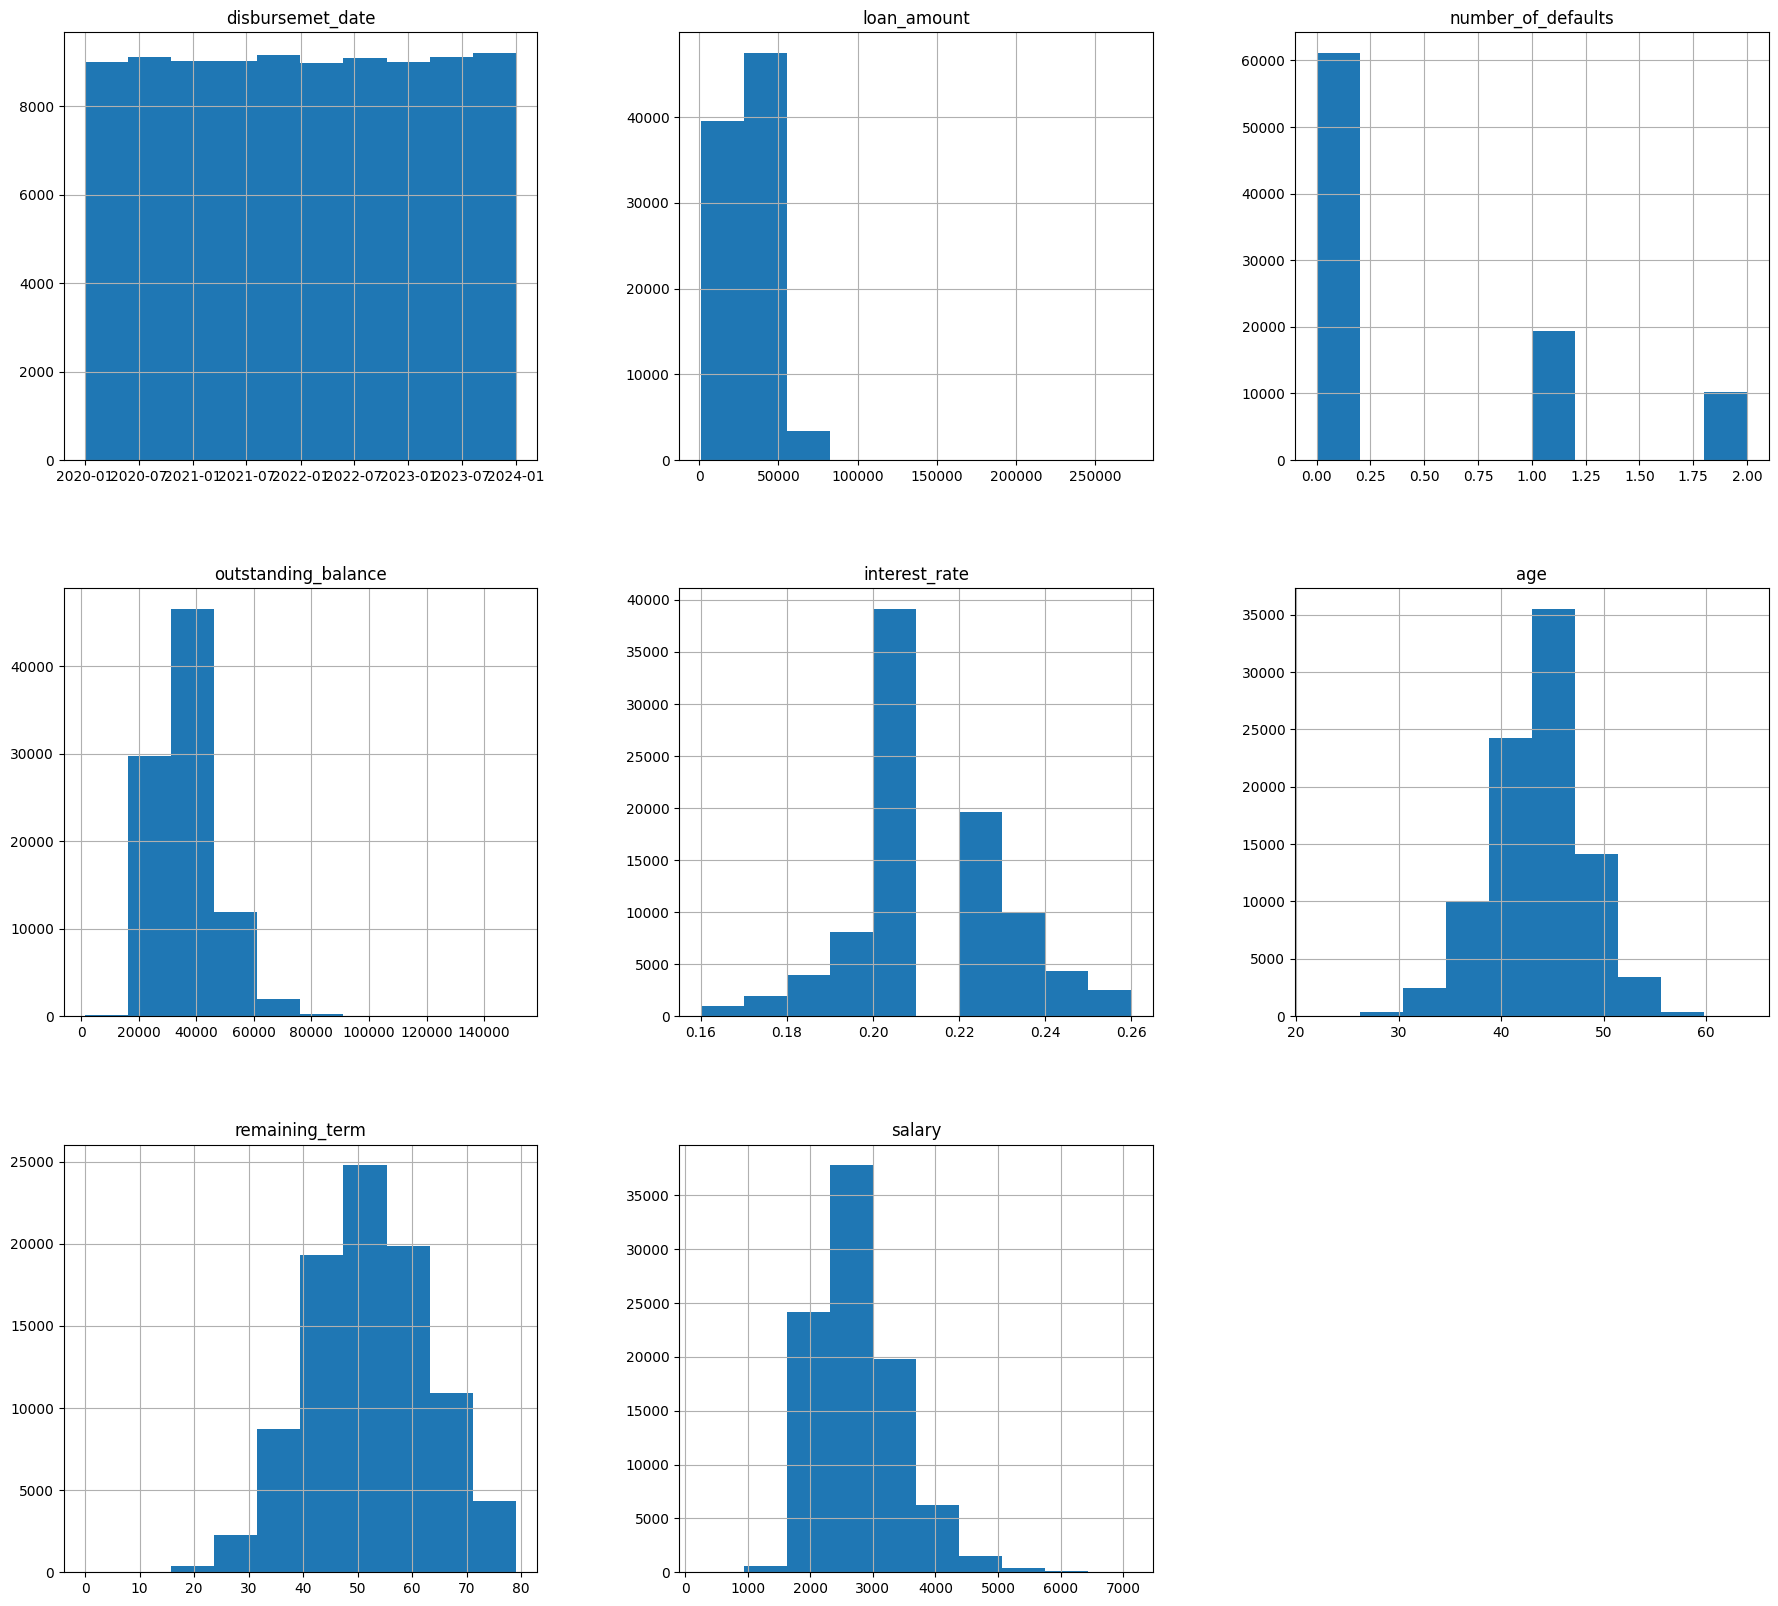

In [ ]:
df.hist(figsize=(22,20))
plt.show()



> Checking for missing values in our dataframe.



In [ ]:
df.isnull().sum()

loan_id                0
gender                 0
disbursemet_date       0
currency               0
country                0
is_employed            0
job                    0
location               0
loan_amount            0
number_of_defaults     0
outstanding_balance    0
interest_rate          0
age                    0
remaining_term         0
salary                 0
marital_status         0
Loan_Status            0
dtype: int64

In [ ]:
#Target feature
df['Loan Status'].value_counts()

Loan Status
Did not default    85134
Defaulted          14866
Name: count, dtype: int64



> Checking the balance on Loan status.



>The imbalance is observed here , as the defaults and non-default are proportionaly have big difference which leads to model predicting better on non defaults but missing a lot on defaults(minority bias).

First 5 entries.

In [ ]:
df.head(5)

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,477cd8a1-3b01-4623-9318-8cd6122a8346,male,2023 02 08,USD,Zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default


> Checking if we are dealing with same currency?

In [ ]:
count_currency = df['currency']
print(count_currency.nunique())

2


>As they are two non unique values then lets see what is the other currency.

In [ ]:
df_with_other_mask= df['currency']!='USD'
df_with_other_currency= df[df_with_other_mask]
df_with_other_currency.shape
df_with_other_currency.head()

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
1836,60c3b33d-6229-4501-a9b6-c5e92f25b8af,other,2023 09 07,$USD,Zimbabwe,other,True,Doctor,Kadoma,48000.0,0,39696.384099,0.22,49,0,45,2665.434835,married,49,Did not default
11227,6c5a5162-c21a-4bf2-8289-3926cc97a837,male,2020 01 01,$USD,Zimbabwe,male,True,Accountant,Marondera,15000.0,2,30100.462815,0.23,39,2,58,2586.125810,divorced,39,Did not default
12878,b99cffad-9ab3-4ddc-8fd3-0cbe5d658ea1,male,2020 07 05,$USD,Zimbabwe,male,True,Doctor,Redcliff,40000.0,0,33016.316831,0.20,38,0,34,2059.155842,,38,Did not default
22301,a43b2f77-2232-4c06-921a-f542fecaff9a,male,2020 05 30,$USD,Zimbabwe,male,True,Doctor,Masvingo,15000.0,0,26227.698479,0.22,38,0,51,2398.910557,divorced,38,Did not default
23224,dfa97ba9-7113-4392-a714-7ec18292ed78,other,2023 10 02,$USD,Zimbabwe,other,True,Software Developer,Rusape,34000.0,0,39024.389403,0.23,40,0,46,2572.715465,divorced,40,Did not default


> How many entries labeled with $?

In [ ]:
#Showing how many entries
df_with_other_currency.shape

(20, 20)

> Removing $ using a function, doing this so that they will be no confussion in data exploration.

In [ ]:
#Cleaning function on values in columns
def clean_currency(value):
    return re.sub(r'\$', '', value)

In [ ]:
#Applying the function
df['currency'] = df['currency'].apply(clean_currency)
print(df['currency'].nunique())

1


In [ ]:
#Checking the function
df_with_other_mask= df['currency']!='USD'
df_with_other_currency= df[df_with_other_mask]
df_with_other_currency.shape
df_with_other_currency.head()

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status


>Succeded removing the dolar sign.

>

>Checking for duplicates?

In [ ]:
# Droping the duplicates rowwise
df=df.drop_duplicates()
df.shape

(100000, 20)

>From the above we have seen duplicates in sex/gender, number of defaults and age. Though they are named differently but containing same data, its unappropriate to have them.

In [ ]:
#lets drop the columns that are duplicated
#droping sex , number_of_defaults.1 and age.1
columns_to_drop =['sex', 'number_of_defaults.1', 'age.1']
df =df.drop(columns_to_drop, axis=1)

  >

>

>Changing date to datime datatype and remaining term to int64 for better representation.

In [ ]:
# Using Pandas
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format ='%Y %m %d')

In [ ]:
df['remaining term']= pd.to_numeric(df['remaining term'], errors= 'coerce')

>

>

>Addressing the missing values in location, country and job status

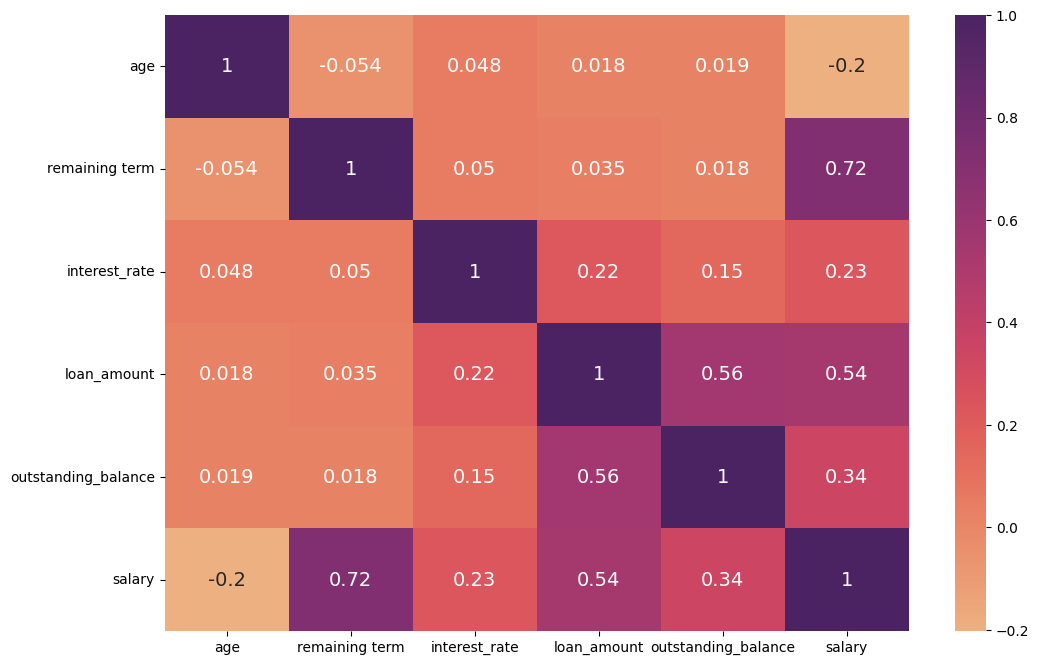

In [ ]:
fig, ax =plt.subplots(figsize =(12,8))
df1= df[['age','remaining term','interest_rate','loan_amount','outstanding_balance','salary']]
corr_matrix = df1.corr()
corr_heatmap = sns.heatmap(corr_matrix, cmap = 'flare', annot = True , ax=ax , annot_kws ={'size':14})
plt.show()

>**Remaining Term and Salary (0.72)**: A strong positive correlation indicates that as the remaining term of a loan increases, the salary of the borrower also tends to increase. This could imply that individuals with higher salaries are more likely to take out longer-term loans, perhaps because they are more confident in their ability to repay over a longer period.

>**Loan Amount and Salary (0.54)**: A moderate positive correlation suggests that individuals with higher salaries tend to take out larger loans. This makes intuitive sense, as lenders often consider income when determining loan eligibility and maximum loan amounts.

>**Loan Amount and Outstanding Balance (0.56)**: A moderate positive correlation is expected here, as the outstanding balance of a loan is directly related to the initial loan amount. The higher the loan amount, the higher the outstanding balance is likely to be, especially in the early stages of repayment.

>"While some variables showed weak correlations (less than 0.5), the strongest relationships were observed between remaining term and salary (0.72), loan amount and salary (0.54), and loan amount and outstanding balance (0.56)."

>

> <b>Scatter showing correlations with higher figures.

> 1. Remaining term and salary (0.72).

Text(0.5, 1.0, 'Salary vs Remaining term')

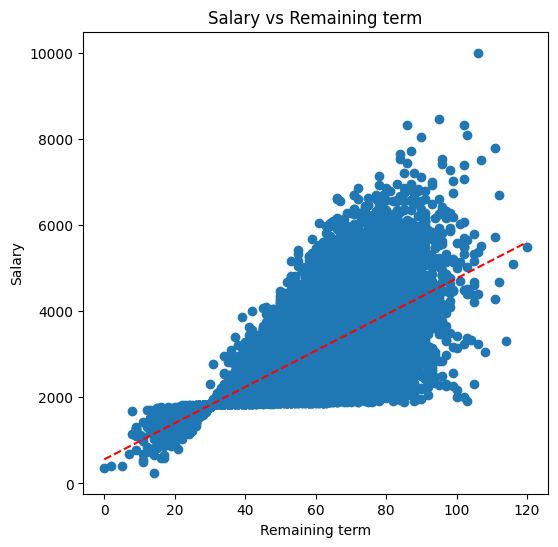

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
x=df["remaining term"]
y=df["salary"]
ax.scatter(x, y)
mean_x = np.mean(x)
mean_y =np.mean(y)
m = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x)) ** 2)
b = mean_y - m * mean_x
x_line = np.linspace(min(x), max(x), 100)
y_line = m*x_line + b
plt.plot(x_line,y_line, linestyle="--", color="red")
plt.xlabel("Remaining term")
plt.ylabel("Salary")
plt.title("Salary vs Remaining term")

>2. salary vs loan_amount scatter.

Text(0.5, 1.0, 'salary vs loan_amount')

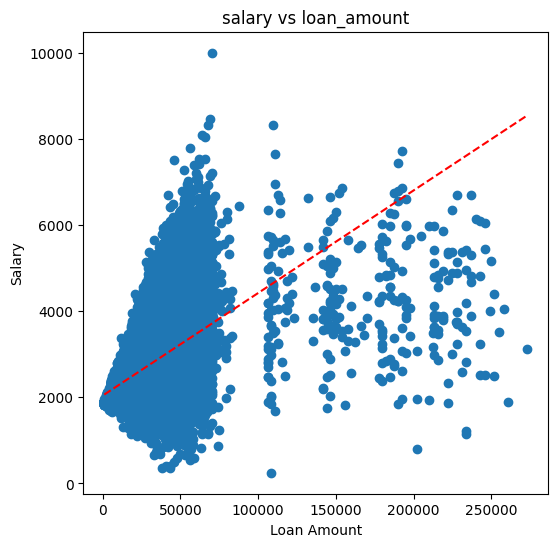

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
x=df["loan_amount"]
y=df["salary"]
ax.scatter(x, y)
mean_x = np.mean(x)
mean_y =np.mean(y)
m = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x)) ** 2)
b = mean_y - m * mean_x
x_line = np.linspace(min(x), max(x), 100)
y_line = m*x_line + b
plt.plot(x_line,y_line, linestyle="--", color="red")
plt.xlabel("Loan Amount")
plt.ylabel("Salary")
plt.title("salary vs loan_amount")

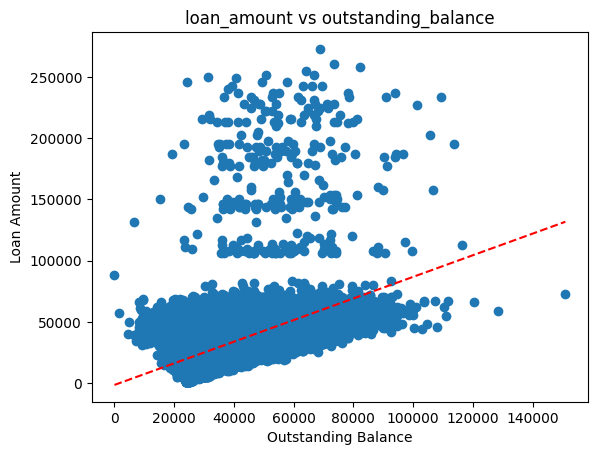

In [ ]:
x=df["outstanding_balance"]
y=df["loan_amount"]
mean_x = np.mean(x)
mean_y =np.mean(y)
m = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x)) ** 2)
b = mean_y - m * mean_x
x_line = np.linspace(min(x), max(x), 100)  # Recalculate x_line
y_line = m*x_line + b
plt.plot(x_line,y_line, linestyle="--", color="red")  # Plot line first
plt.scatter(x, y)  # Plot scatter after
plt.xlabel("Outstanding Balance")
plt.ylabel("Loan Amount")
plt.title("loan_amount vs outstanding_balance")
plt.show()

>1. Loan Status.

In [ ]:
data3 = pd.crosstab(
    index=df["number_of_defaults"],
    columns=df["Loan Status"],
    normalize=False
)

print("data type:", type(data3))
print("data shape:", data3.shape)
data3

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (3, 2)


Loan Status,Defaulted,Did not default
number_of_defaults,,
0,7517,59641
1,4375,17112
2,2974,8381


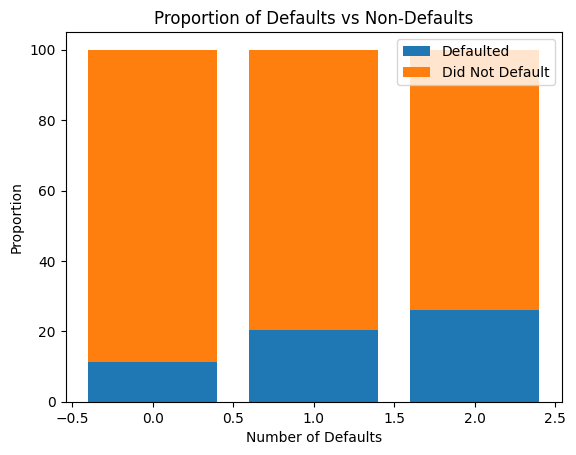

In [ ]:
# Proportion of Defaults vs Non-Defaults


number_of_defaults = [0, 1, 2]
Defaulted = [7517, 4375, 2974]
Did_not_default = [59641, 17112, 8381]

total = [i + j for i, j in zip(Defaulted, Did_not_default)]
default_proportion = [i / j * 100 for i, j in zip(Defaulted, total)]
non_default_proportion = [i / j * 100 for i, j in zip(Did_not_default, total)]

plt.bar(number_of_defaults, default_proportion, label='Defaulted')
plt.bar(number_of_defaults, non_default_proportion, bottom=default_proportion, label='Did Not Default')

plt.xlabel("Number of Defaults")
plt.ylabel("Proportion")
plt.title("Proportion of Defaults vs Non-Defaults")
_ = plt.legend()


In [ ]:
df['Loan Status'].describe()

count              100000
unique                  2
top       Did not default
freq                85134
Name: Loan Status, dtype: object

>2. Marital Status..

In [ ]:
data2 = pd.crosstab(
    index=df["Loan Status"],
    columns=df["marital_status"],
    normalize=False
)

print("data type:", type(data2))
print("data shape:", data2.shape)
data2

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 4)


marital_status,,divorced,married,single
Loan Status,,,,
Defaulted,479,4749,6831,2807
Did not default,2648,21716,37879,22891


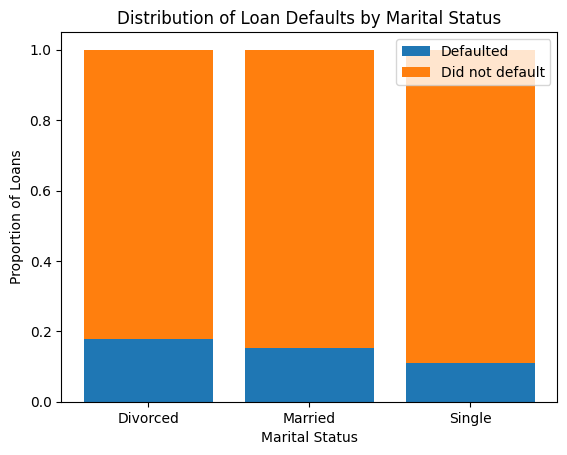

In [ ]:
#Distribution of Loan Defaults by Marital Status


defaulted = [data2['divorced'][1] / (data2['divorced'][0] + data2['divorced'][1]),
             data2['married'][1] / (data2['married'][0] + data2['married'][1]),
             data2['single'][1] / (data2['single'][0] + data2['single'][1])]
not_defaulted = [1 - defaulted[0], 1 - defaulted[1], 1 - defaulted[2]]

labels = ['Divorced', 'Married', 'Single']

plt.bar(labels, not_defaulted, label='Defaulted')
plt.bar(labels, defaulted, bottom=not_defaulted, label='Did not default')

plt.xlabel('Marital Status')
plt.ylabel('Proportion of Loans')
plt.title('Distribution of Loan Defaults by Marital Status')
_ = plt.legend()


> Divorced has highest defaults with respect to the total of their pool.

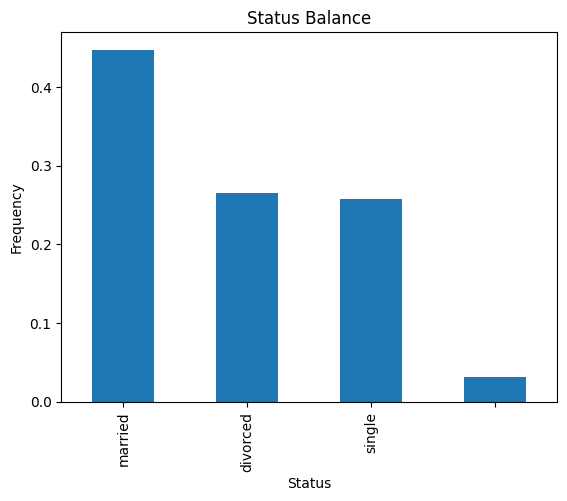

In [ ]:
# Plot class balance
df["marital_status"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Status",
    ylabel="Frequency",
    title="Status Balance"
);

> Married people are mostly the target market from the above showing a bigger chunk.

In [ ]:
print(df['marital_status'].value_counts())

marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64


In [ ]:
df['marital_status'].describe()

count      100000
unique          4
top       married
freq        44710
Name: marital_status, dtype: object

from the above we see other component that is anonymous later to be edited to other.

>3. Number of defaults

In [ ]:
data = pd.crosstab(
    index=df["Loan Status"],
    columns=df["number_of_defaults"],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 3)


number_of_defaults,0,1,2
Loan Status,,,
Defaulted,7517,4375,2974
Did not default,59641,17112,8381


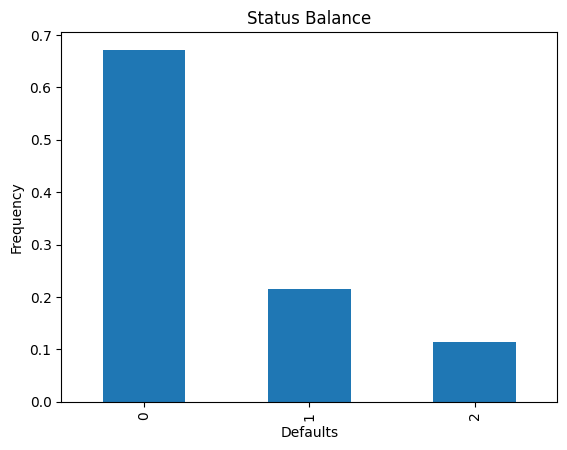

In [ ]:
 # Plot class balance
df["number_of_defaults"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Defaults",
    ylabel="Frequency",
    title="Status Balance"
);

>a good start, as majority of the clients did not default.

In [ ]:
print(df['number_of_defaults'].value_counts())

number_of_defaults
0    67158
1    21487
2    11355
Name: count, dtype: int64


In [ ]:
df['number_of_defaults'].describe()

count    100000.000000
mean          0.441970
std           0.688286
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           2.000000
Name: number_of_defaults, dtype: float64

>4. Locations.

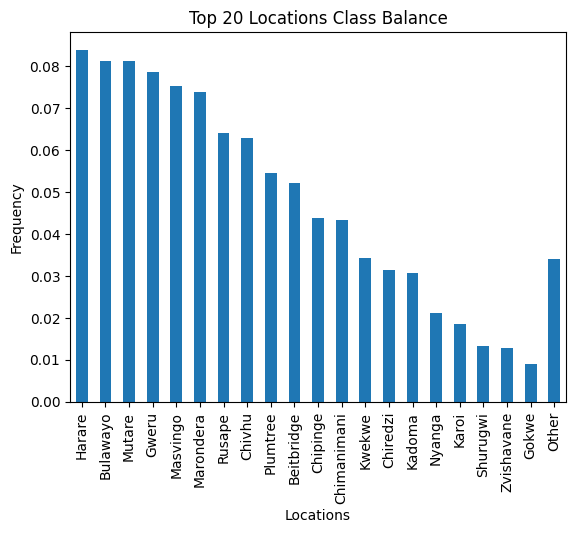

In [ ]:
top_n = 20
top_locations = df["location"].value_counts(normalize=True).nlargest(top_n)
other_locations_freq = 1 - top_locations.sum()
top_locations['Other'] = other_locations_freq

top_locations.plot(kind='bar', xlabel='Locations', ylabel='Frequency', title=f'Top {top_n} Locations Class Balance')
plt.show()

>the loans are being taken mostly in Harare and decrease as the above, so there is need to explore other locations as well.

In [ ]:
print(df['location'].value_counts().nlargest(top_n))

location
Harare         8338
Bulawayo       8078
Mutare         8062
Gweru          7803
Masvingo       7476
Marondera      7343
Rusape         6378
Chivhu         6257
Plumtree       5431
Beitbridge     5181
Chipinge       4358
Chimanimani    4296
Kwekwe         3401
Chiredzi       3123
Kadoma         3049
Nyanga         2099
Karoi          1850
Shurugwi       1322
Zvishavane     1276
Gokwe           901
Name: count, dtype: int64


In [ ]:
df['location'].describe()

count      99405
unique       157
top       Harare
freq        8338
Name: location, dtype: object

In [ ]:
unique_locations =df['location'].unique()

In [ ]:
unique_locations.shape

(158,)

In [ ]:
unique = pd.DataFrame(unique_locations, columns= ['locations'])

In [ ]:
unique.head(-5)

,locations
0,Beitbridge
1,Harare
2,Gweru
3,Rusape
4,Chipinge
...,...
148,Kariba
149,Victoria Falls
150,Victoria Falls
151,Nyanga


>5. Jobs.

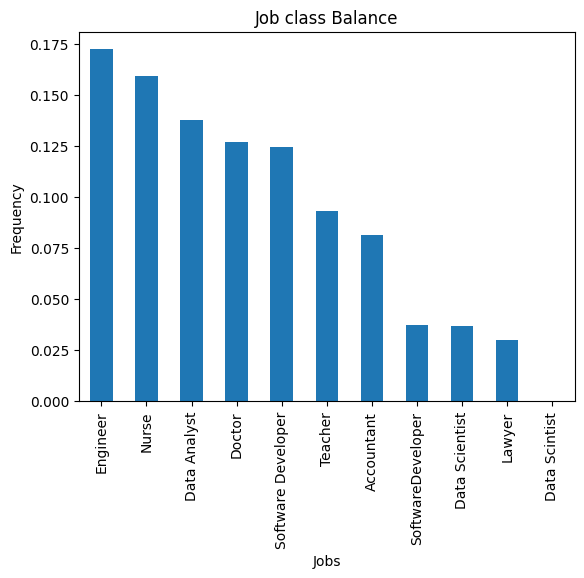

In [ ]:
 # Plot class balance
df["job"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Jobs",
    ylabel="Frequency",
    title="Job class Balance"
);

In [ ]:
print(df['job'].value_counts())

job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64


In [ ]:
df['job'].describe()

count        95864
unique          11
top       Engineer
freq         16524
Name: job, dtype: object

>6. Loan Amount.

In [ ]:
print(df['loan_amount'].value_counts())

loan_amount
5000.0      3639
33000.0     2877
32000.0     2839
35000.0     2811
29000.0     2804
            ... 
168000.0       1
240000.0       1
178000.0       1
250000.0       1
249000.0       1
Name: count, Length: 149, dtype: int64


In [ ]:
df['loan_amount'].describe()

count    100000.000000
mean      31120.000000
std       15895.093631
min        1000.000000
25%       21000.000000
50%       31000.000000
75%       40000.000000
max      273000.000000
Name: loan_amount, dtype: float64

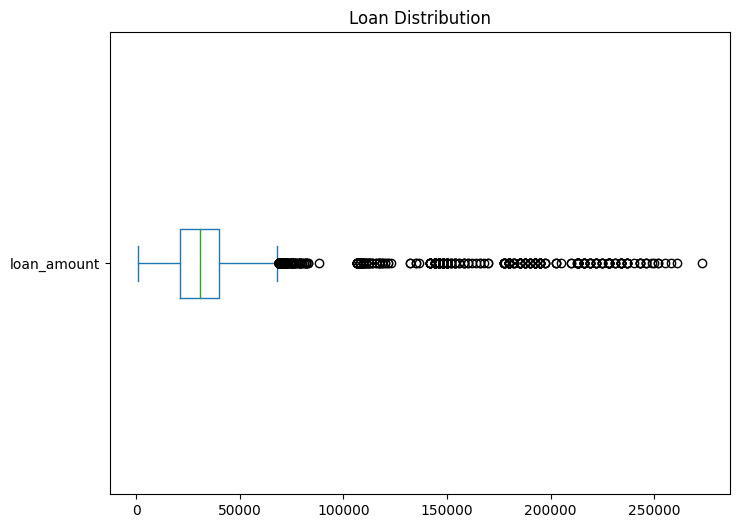

In [ ]:
fig, ax =plt.subplots(figsize= (8,6))
df['loan_amount'].plot(kind= "box", vert= False, title='Loan Distribution', ax=ax)
plt.show()

>7. Interest rate..

In [ ]:
print(df['interest_rate'].value_counts())

interest_rate
0.21    25514
0.22    21412
0.20    17647
0.23    10854
0.19     8743
0.24     4726
0.18     4259
0.17     2087
0.25     1964
0.16     1056
0.26      717
0.15      454
0.27      225
0.14      182
0.28       64
0.13       53
0.12       28
0.29        9
0.11        3
0.10        2
0.30        1
Name: count, dtype: int64


In [ ]:
df['interest_rate'].describe()

count    100000.000000
mean          0.210435
std           0.018725
min           0.100000
25%           0.200000
50%           0.210000
75%           0.220000
max           0.300000
Name: interest_rate, dtype: float64

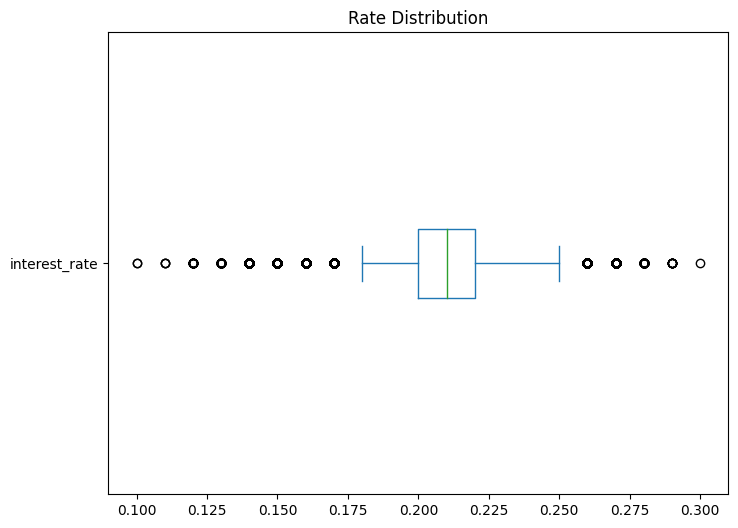

In [ ]:
fig, ax =plt.subplots(figsize= (8,6))
df['interest_rate'].plot(kind= "box", vert= False, title='Rate Distribution', ax=ax)
plt.show()

>8. Age.

In [ ]:
print(df['age'].value_counts())

age
43    8263
44    8245
45    7905
42    7893
46    7418
41    7089
47    6614
40    6208
48    5627
39    5024
49    4409
38    4017
50    3397
37    3141
51    2569
36    2259
52    1759
35    1695
53    1205
34    1185
33     803
54     759
32     548
55     471
31     319
56     304
30     251
57     139
29     122
58      95
28      80
59      43
27      38
60      35
26      30
25      10
23       7
61       7
24       5
63       4
64       3
22       2
62       1
21       1
65       1
Name: count, dtype: int64


In [ ]:
df['age'].describe()

count    100000.00000
mean         43.57069
std           4.86376
min          21.00000
25%          40.00000
50%          44.00000
75%          47.00000
max          65.00000
Name: age, dtype: float64

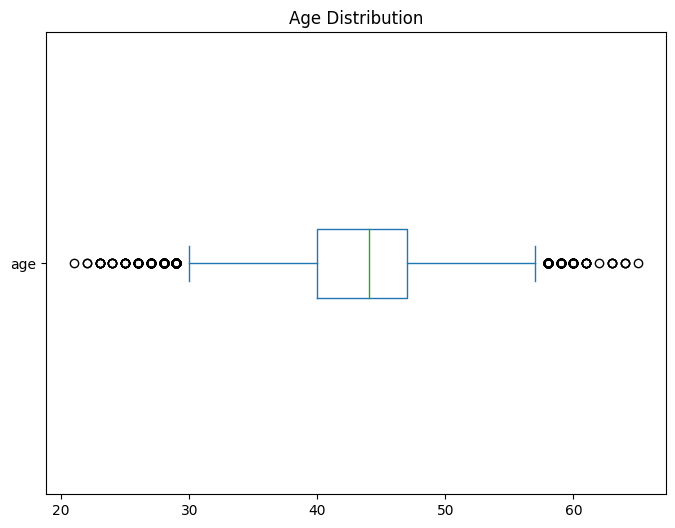

In [ ]:
fig, ax =plt.subplots(figsize= (8,6))
df['age'].plot(kind= "box", vert= False, title='Age Distribution', ax=ax)
plt.show()




>9. Remaining term.

In [ ]:
print(df['remaining term'].value_counts())

remaining term
51.0     3393
49.0     3381
53.0     3374
54.0     3330
50.0     3294
         ... 
2.0         1
0.0         1
7.0         1
114.0       1
5.0         1
Name: count, Length: 110, dtype: int64


In [ ]:
df['remaining term'].describe()

count    98125.000000
mean        52.892708
std         11.984802
min          0.000000
25%         45.000000
50%         52.000000
75%         61.000000
max        120.000000
Name: remaining term, dtype: float64

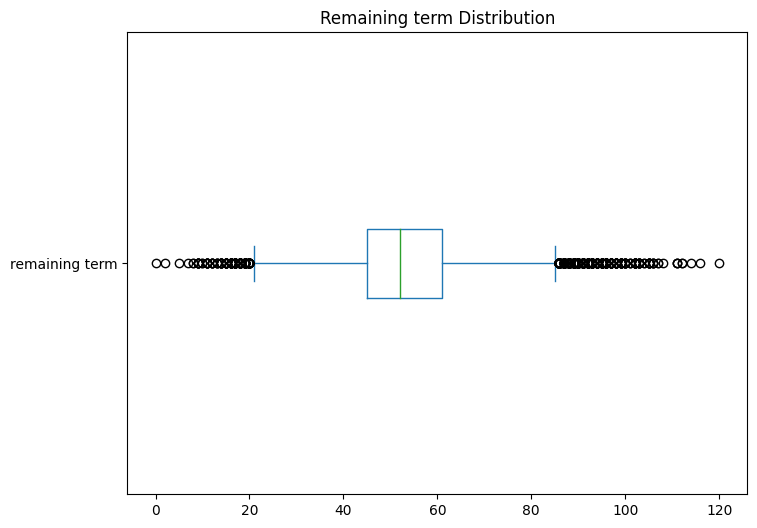

In [ ]:
fig, ax =plt.subplots(figsize= (8,6))
df['remaining term'].plot(kind= "box", vert= False, title='Remaining term Distribution', ax=ax)
plt.show()

>10. Salary.

In [ ]:
print(df['salary'].value_counts())


salary
3230.038869    1
2366.568768    1
1910.662717    1
3047.842940    1
2141.820483    1
              ..
1925.734322    1
3220.816426    1
3606.815823    1
2637.311845    1
2670.766532    1
Name: count, Length: 100000, dtype: int64


In [ ]:
df['salary'].describe()

count    100000.000000
mean       2781.804324
std         696.450055
min         250.000000
25%        2273.929349
50%        2665.441567
75%        3146.577655
max       10000.000000
Name: salary, dtype: float64

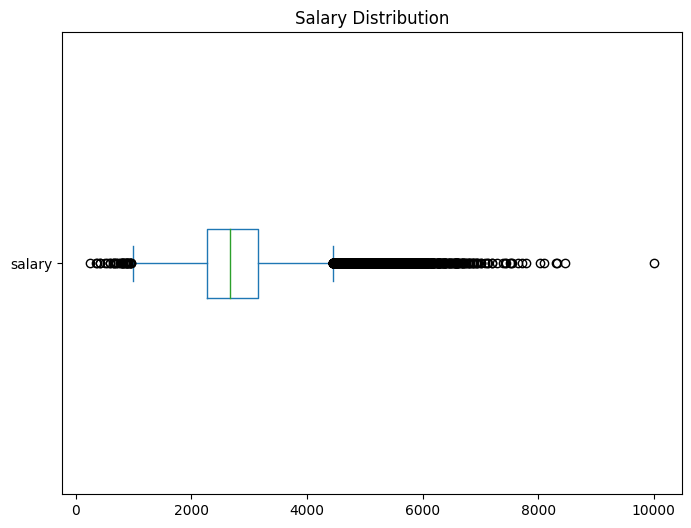

In [ ]:
fig, ax =plt.subplots(figsize= (8,6))
df['salary'].plot(kind= "box", vert= False, title='Salary Distribution', ax=ax)
plt.show()

In [ ]:
print(df['gender'].value_counts())

gender
male      35028
female    32685
other     32287
Name: count, dtype: int64


In [ ]:
df['gender'].describe()

count     100000
unique         3
top         male
freq       35028
Name: gender, dtype: object

>Cleaning outliers.

In [ ]:
 # remaining term
df = df[df["remaining term"]<80]

> The remaining term never get over this 80 yrs as this is confusing to say it will be there even you gone/died.

>

>

>

# Feature engineering..

In [ ]:
label_encoder = LabelEncoder()
for col in ['gender', 'is_employed']:
    df[col] = label_encoder.fit_transform(df[col])

>Label encoding converts categorical values into numerical labels, allowing the model to understand and utilize the information contained in these features.

In [ ]:
df.head()

,loan_id,gender,disbursemet_date,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining_term,salary,marital_status,Loan_Status
0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,0,2022-10-29,USD,Zimbabwe,0,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,47.0,3230.038869,married,Did not default
1,368bf756-fcf2-4822-9612-f445d90b485b,2,2020-06-06,USD,Zimbabwe,0,Teacher,Harare,27000.0,2,28752.062237,0.20,43,62.0,3194.139103,single,Did not default
2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,2,2023-09-29,USD,Zimbabwe,0,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,57.0,3330.826656,married,Did not default
3,191c62f8-2211-49fe-ba91-43556b307871,0,2022-06-22,USD,Zimbabwe,0,Doctor,Rusape,24000.0,0,35681.496413,0.23,47,42.0,2246.797020,divorced,Did not default
4,477cd8a1-3b01-4623-9318-8cd6122a8346,1,2023-02-08,USD,Zimbabwe,0,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,45.0,2310.858441,married,Did not default


 ## Feature engineering using OneHotEncoder.

In [ ]:
onehot_encoder = OneHotEncoder(sparse_output= False)
df['Loan_Status'] = onehot_encoder.fit_transform(df['Loan_Status'].values.reshape(-1, 1) )

>One-Hot Encoding ensures that each category is represented equally in the feature space, preventing any single category from dominating the learning process due to a higher numerical label.

In [ ]:
categ_features = ['country', 'job', 'location', 'marital_status']

striped = df.drop(categ_features, axis=1)

onehot_encoder = OneHotEncoder(sparse_output = False)
# Transform the features, rename the columns with the _count suffix, and join to dataframe
df1 = onehot_encoder.fit_transform(df[categ_features])

encoded_df = pd.DataFrame(df1)

encoded_df.columns = onehot_encoder.get_feature_names_out(categ_features)
df1 = pd.concat([striped, encoded_df], axis=1, join ='inner')

>This prepares the categorical features for use in machine learning models that require numerical input. One-Hot Encoding is crucial for handling categorical data without implying any ordinal relationships between categories.

>One-Hot Encoding is the appropriate choice for your categorical features because it accurately represents their nominal nature, avoids potential misinterpretations, and enables effective use of these features in machine learning models.

In [ ]:
df1.shape

(82232, 186)

## Split.

>Creating our feature matrix <b>X</b> and target vector <b>y</b>. Our target is "Loan Status"

>Selecting features where based on domain knowledge, 'loan_id','disbursemet_date', 'currency','Loan_Status', these are not going to contribute anything to the learning of the algorythm.

In [ ]:
X = df1.drop(labels=['loan_id','disbursemet_date', 'currency','Loan_Status'], axis=1)
y = df1["Loan_Status"]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (82232, 182)
y shape: (82232,)



>Dealing with the imbalance!

>Since we're not working with time series data, we're going to randomly divide our dataset into training and test sets using train_test_split.

>Essential for assessing the true performance of a machine learning model and ensuring that it can generalize to new data, ultimately leading to more reliable and effective predictions.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (74008, 182)
y_train shape: (74008,)
X_test shape: (8224, 182)
y_test shape: (8224,)


## Resampling.

>Creating a new feature matrix by performing random over-sampling, undersampling and smote on the training data. Addressing imbalanced classes.

###  Oversampling.



---

By increasing the number of samples in the minority class, oversampling helps the model learn the patterns and characteristics of that class more effectively.
This leads to better predictions and reduced bias towards the majority class.

In [ ]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)

X_train_over shape: (127868, 182)


###  Undersampling.



---
Undersampling helps level the playing field by reducing the dominance of the majority class, allowing the model to focus more on the minority class.


In [ ]:
under_sampler =RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)

(20148, 182)


###  Synthetic Minority Over-sampling Technique.



---

By providing the model with a more diverse set of minority class examples, SMOTE helps it learn to generalize better to unseen data from that class.

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=8)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape)

(127868, 182)


# Scaling data.



---
**Use of StandardScaler**.
Standardizing features can help reduce the impact of outliers, as they are scaled down relative to the other data points.

1. oversampled data.

In [ ]:
scaler = StandardScaler()
# Fit and transform the training data
X_train_scaled_over = pd.DataFrame(scaler.fit_transform(X_train_over), columns=X_train_over.columns)

# Transform the test data using the same scaler
X_test_scaled_over = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



---



2. undersampled data

In [ ]:
# Fit and transform the training data
X_train_scaled_under = pd.DataFrame(scaler.fit_transform(X_train_under), columns=X_train_under.columns)

# Transform the test data using the same scaler
X_test_under = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



---



3. raw data.

In [ ]:
# Fit and transform the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)


# Transform the test data using the same scaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)




---



4. SMOTE data.

In [ ]:
# Fit and transform the training data
X_train_smote = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

# Transform the test data using the same scaler
X_test_smote = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)




---


---




# Model building.

>*Now* that we have our data set up the right way, we can build the model. 🏗

>Baseline accuracy score for our model.

In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.8639


## a) XGBoostClassifier.



---

In my models i used GridSearch as it systematically explores a specified range of hyperparameter values to find the combination that yields the best model performance. or in short Automated Hyperparameter Optimization(AHO).

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
# oversampled data model.
pipe = Pipeline([
    ('scaling', FunctionTransformer(lambda x:x)),
    ('xgboost', XGBClassifier(objective= 'binary:logistic'))
])

parameters = {'xgboost__max_depth': [70],
              'xgboost__n_estimators' : [100],
              'xgboost__learning_rate' : [0.09],
              'xgboost__tree_method': ['hist'],
              'xgboost__min_child_weight': [1],
              'xgboost__gamma': [0.5],
              'xgboost__subsample': [0.8],
              'xgboost__colsample_bytree': [0.8],
              'xgboost__scale_pos_weight': [1]
              }


gs = GridSearchCV(pipe, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=10)

gs.fit(X_train_scaled_over, y_train_over)

best_model = gs.best_estimator_
y_test_proba = best_model.predict_proba(X_test_scaled)
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print('LR ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))
print(f"Accuracy: {accuracy:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


LR ROC AUC: 0.8113536008913138
Accuracy: 0.8510


(0.0, 1.05)

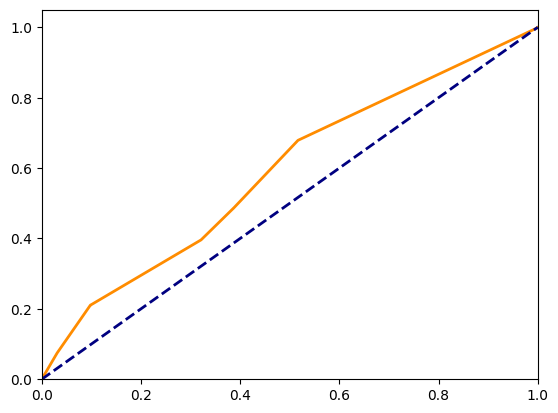

In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

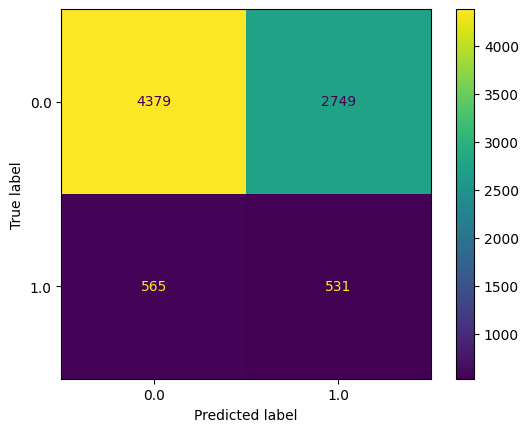

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.614337822671156
F1 Score: 0.7254804506295559




---



In [ ]:
# undersampled data model.

pipe1 = Pipeline([
    ('scaling', FunctionTransformer(lambda x:x)),
    ('xgboost', XGBClassifier(objective= 'binary:logistic'))
])

parameters = {'xgboost__max_depth': [70],
              'xgboost__n_estimators' : [100],
              'xgboost__learning_rate' : [0.09],
              'xgboost__tree_method': ['hist'],
              'xgboost__min_child_weight': [1],
              'xgboost__gamma': [0.5],
              'xgboost__subsample': [0.8],
              'xgboost__colsample_bytree': [0.8],
              'xgboost__scale_pos_weight': [1]
              }


gs1 = GridSearchCV(pipe1, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=10)

gs1.fit(X_train_scaled_under, y_train_under)

best_model1 = gs1.best_estimator_
y_test_proba1 = best_model1.predict_proba(X_test_under)
y_pred1 = best_model1.predict(X_test_under)
accuracy1 = accuracy_score(y_test, y_pred1)
print('LR ROC AUC:', roc_auc_score(y_test, y_test_proba1[:, 1]))
print(f"Accuracy: {accuracy1:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
LR ROC AUC: 0.8139700558914367
Accuracy: 0.7645


(0.0, 1.05)

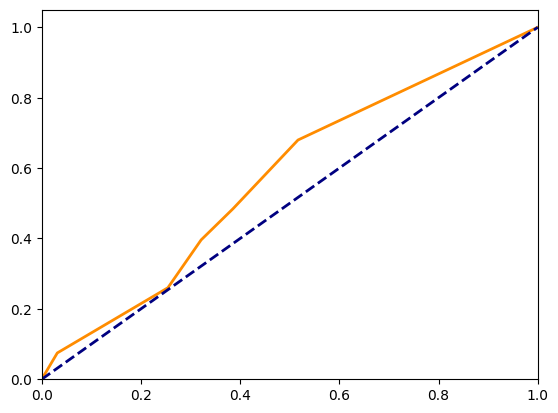

In [ ]:
y_pred_proba = best_model1.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

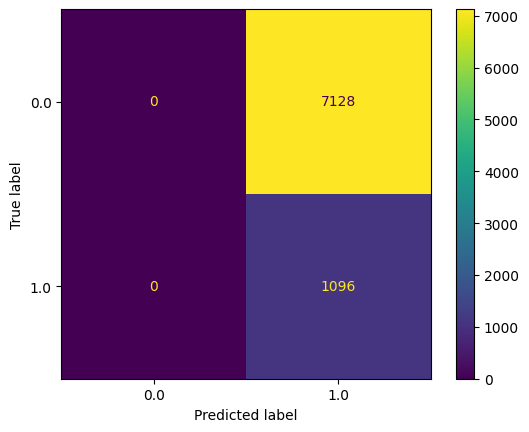

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model1, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, best_model1.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.0
F1 Score: nan


<ipython-input-133-656788b9ca26>:20: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)




---



In [ ]:
# not edited data model.

pipe2 = Pipeline([
    ('scaling', FunctionTransformer(lambda x:x)),
    ('xgboost', XGBClassifier(objective= 'binary:logistic'))
])

parameters = {'xgboost__max_depth': [70],
              'xgboost__n_estimators' : [100],
              'xgboost__learning_rate' : [0.09],
              'xgboost__tree_method': ['hist'],
              'xgboost__min_child_weight': [1],
              'xgboost__gamma': [0.5],
              'xgboost__subsample': [0.8],
              'xgboost__colsample_bytree': [0.8],
              'xgboost__scale_pos_weight': [1]
              }


gs2 = GridSearchCV(pipe2, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=10)

gs2.fit(X_train_scaled, y_train)

best_model2 = gs2.best_estimator_
y_test_proba2 = best_model2.predict_proba(X_test_scaled)
y_pred2 = best_model2.predict(X_test_scaled)
accuracy2 = accuracy_score(y_test, y_pred2)
print('LR ROC AUC:', roc_auc_score(y_test, y_test_proba2[:, 1]))
print(f"Accuracy: {accuracy2:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
LR ROC AUC: 0.8143964994634094
Accuracy: 0.9014


(0.0, 1.05)

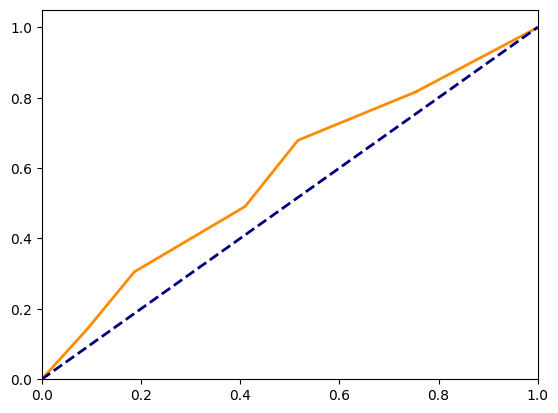

In [ ]:
y_pred_proba = best_model2.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

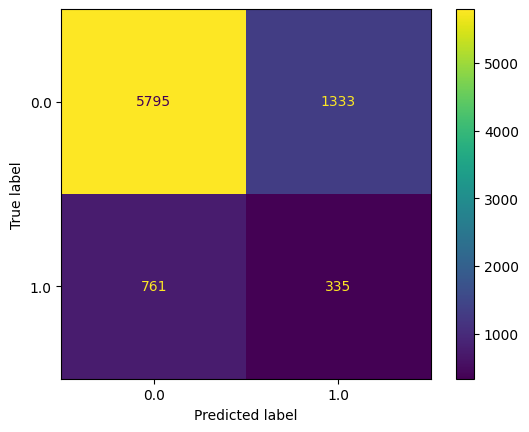

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model2, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, best_model2.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.8129910213243546
F1 Score: 0.8469745688395206




---



In [ ]:
# smote data model.

pipe3 = Pipeline([
    ('scaling', FunctionTransformer(lambda x:x)),
    ('xgboost', XGBClassifier(objective= 'binary:logistic'))
])

parameters = {'xgboost__max_depth': [70],
              'xgboost__n_estimators' : [100],
              'xgboost__learning_rate' : [0.09],
              'xgboost__tree_method': ['hist'],
              'xgboost__min_child_weight': [1],
              'xgboost__gamma': [0.5],
              'xgboost__subsample': [0.8],
              'xgboost__colsample_bytree': [0.8],
              'xgboost__scale_pos_weight': [1]
              }


gs3 = GridSearchCV(pipe3, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=10)

gs3.fit(X_train_smote, y_resampled)

best_model3 = gs3.best_estimator_
y_test_proba3 = best_model3.predict_proba(X_test_smote)
y_pred3 = best_model3.predict(X_test_smote)
accuracy3 = accuracy_score(y_test, y_pred3)
print('LR ROC AUC:', roc_auc_score(y_test, y_test_proba3[:, 1]))
print(f"Accuracy: {accuracy3:.4f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
LR ROC AUC: 0.8076511644219978
Accuracy: 0.8970


(0.0, 1.05)

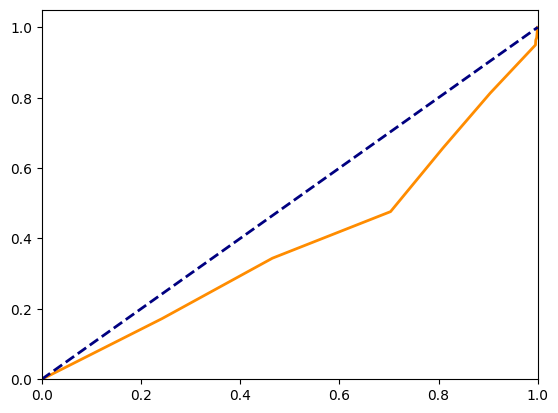

In [ ]:
y_pred_proba = best_model3.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

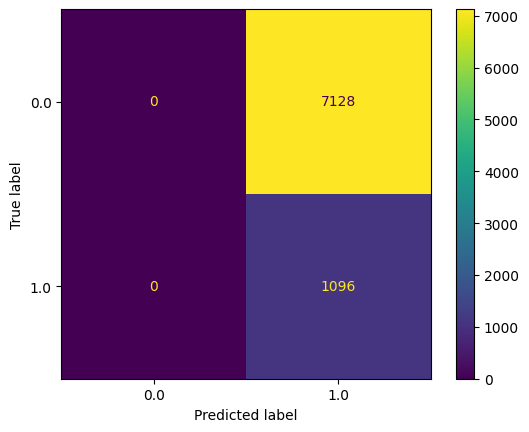

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model3, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, best_model3.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

NameError: name 'confusion_matrix' is not defined

In [ ]:
# Assuming you have variables storing the model names and metrics
model_names = ['best_model','best_model1', 'best_model2', 'best_model3']
roc_auc_scores = [0.8113536008913138, 0.8139700558914367,0.8143964994634094, 0.8076511644219978]
accuracy_scores = [0.851, 0.7676, 0.901, 0.8970]
Precision = [0.614337822671156, 0.0,0.8129910213243546,0.0]
F1_Score= [0.7254804506295559,'nan', 0.8469745688395206,'nan']
# Create a dictionary using the variables
data = {'Model': model_names,
        'ROC AUC': roc_auc_scores,
        'Accuracy': accuracy_scores,
        'Precision': Precision,
        'F1_Score': F1_Score
        }

Table = pd.DataFrame(data)
table = tabulate(Table, headers='keys', tablefmt='psql')
print(table)

+----+-------------+-----------+------------+-------------+------------+
|    | Model       |   ROC AUC |   Accuracy |   Precision |   F1_Score |
|----+-------------+-----------+------------+-------------+------------|
|  0 | best_model  |  0.811354 |     0.851  |    0.614338 |   0.72548  |
|  1 | best_model1 |  0.81397  |     0.7676 |    0        | nan        |
|  2 | best_model2 |  0.814396 |     0.901  |    0.812991 |   0.846975 |
|  3 | best_model3 |  0.807651 |     0.897  |    0        | nan        |
+----+-------------+-----------+------------+-------------+------------+


**Analysis**:


---


**best_model** shows a balanced performance with a decent ROC AUC (0.811354), accuracy (0.851), precision (0.614338), and a calculated F1-score (0.725480). This indicates it handles both classes relatively well.

**best_model1** and **best_model3**, despite having reasonable ROC AUC scores, suffer from zero precision, rendering their F1-scores undefined. This suggests a high false-positive rate, which is a critical issue for classification tasks, especially when dealing with imbalanced datasets.

**best_model2** edges it out with better scores across all metrics. High F1-Score (0.846975): Confirms a good balance between precision and recall, crucial for imbalanced datasets where identifying the minority class is vital.


---


**Key takeaway**: F1-score for best_model2 (0.846975), we can confidently say it's likely the best model

In [ ]:
with open('best-xgb-class.pkl', 'wb') as f:
    dill.dump(best_model2, f)



---



---



## b) DecisionTreeClassifier.

>Params being used are already hypertuned already by GridSearch.

In [ ]:
from sklearn.impute import SimpleImputer
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
param_grid = {
    'simpleimputer__strategy': ['mean'],
    'decisiontreeclassifier__criterion': ['entropy'],
    'decisiontreeclassifier__max_depth': [10],
    'decisiontreeclassifier__min_samples_split': [2],
    'decisiontreeclassifier__min_samples_leaf': [4]
}

model_reg.fit(X_train, y_train)

acc_train = model_reg.score(X_train_scaled,y_train)
acc_test = model_reg.score(X_test_scaled, y_test)
y_pred_proba = model_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))
# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)

Training Accuracy: 0.7902
Test Accuracy: 0.7923
ROC AUC Score: 0.6345731237762868


(0.0, 1.05)

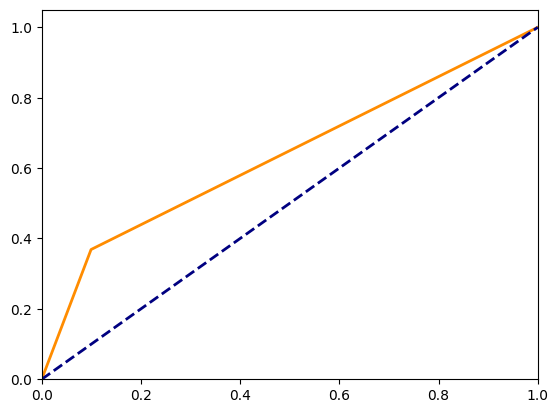

In [ ]:
y_pred_proba = model_reg.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

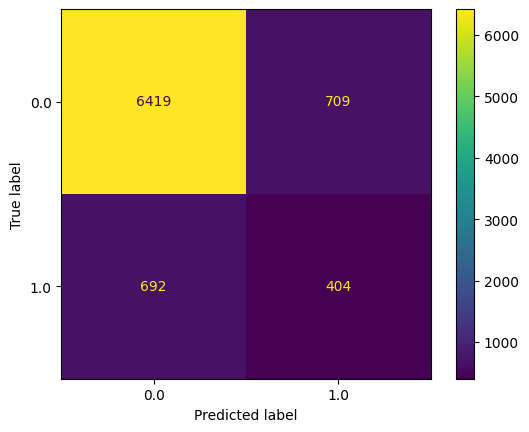

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_reg.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.9005331088664422
F1 Score: 0.9016082590069527




---



In [ ]:
# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
param_grid = {
    'simpleimputer__strategy': ['mean'],
    'decisiontreeclassifier__criterion': ['entropy'],
    'decisiontreeclassifier__max_depth': [10],
    'decisiontreeclassifier__min_samples_split': [2],
    'decisiontreeclassifier__min_samples_leaf': [4]
}

model_under.fit(X_train_scaled_under, y_train_under)

acc_train = model_under.score(X_train_scaled_under,y_train_under)
acc_test = model_under.score(X_test_under, y_test)
y_pred_proba = model_under.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))
# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)

Training Accuracy: 1.0
Test Accuracy: 0.659
ROC AUC Score: 0.5


(0.0, 1.05)

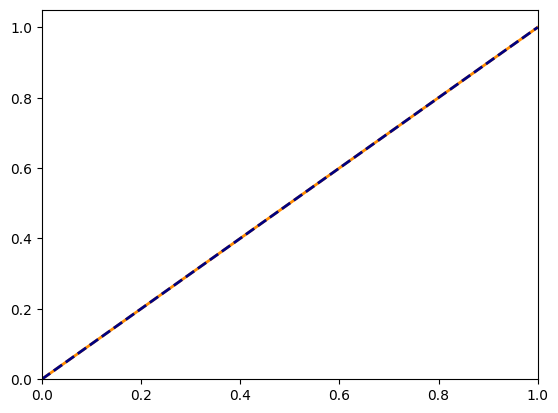

In [ ]:
y_pred_proba = model_under.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

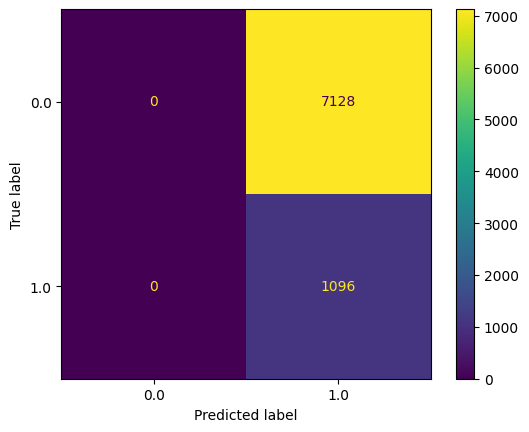

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_under, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_under.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.0
F1 Score: nan


<ipython-input-152-78342eeb2bfe>:20: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)




---



In [ ]:
# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
param_grid = {
    'simpleimputer__strategy': ['mean'],
    'decisiontreeclassifier__criterion': ['entropy'],
    'decisiontreeclassifier__max_depth': [10],
    'decisiontreeclassifier__min_samples_split': [2],
    'decisiontreeclassifier__min_samples_leaf': [4]
}

model_over.fit(X_train_scaled_over, y_train_over)

acc_train = model_over.score(X_train_scaled_over, y_train_over)
acc_test = model_over.score(X_test_scaled_over, y_test)
y_pred_proba = model_over.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))
# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)

Training Accuracy: 1.0
Test Accuracy: 0.8279
ROC AUC Score: 0.4438592125635921


(0.0, 1.05)

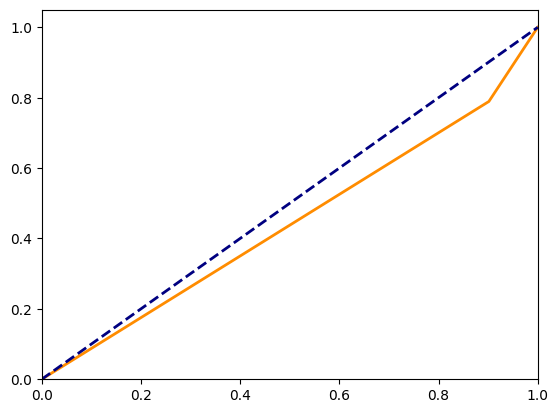

In [ ]:
y_pred_proba = model_over.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

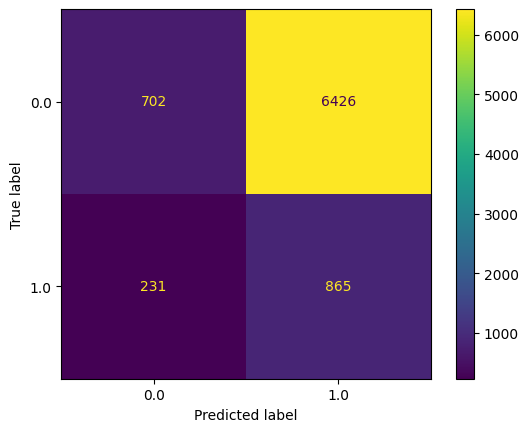

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_over.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.09848484848484848
F1 Score: 0.1741719389653889


In [ ]:
# Fit on `X_train_over`, `y_train_over`
model_smote = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
param_grid = {
    'simpleimputer__strategy': ['mean'],
    'decisiontreeclassifier__criterion': ['entropy'],
    'decisiontreeclassifier__max_depth': [10],
    'decisiontreeclassifier__min_samples_split': [2],
    'decisiontreeclassifier__min_samples_leaf': [4]
}

model_smote.fit(X_resampled, y_resampled)

acc_train = model_smote.score(X_resampled,y_resampled)
acc_test = model_smote.score(X_test_smote, y_test)
y_pred_proba = model_smote.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))
# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)

Training Accuracy: 1.0
Test Accuracy: 0.4005
ROC AUC Score: 0.6256640820205297


(0.0, 1.05)

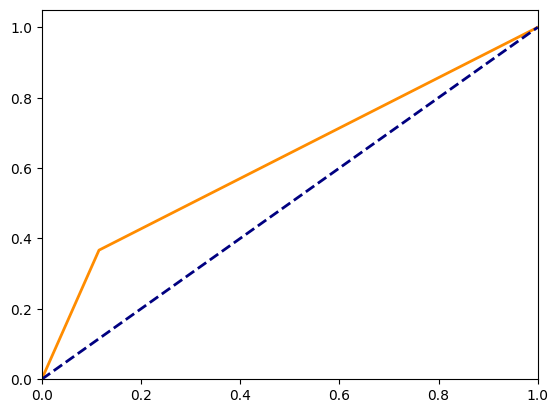

In [ ]:
y_pred_proba = model_smote.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

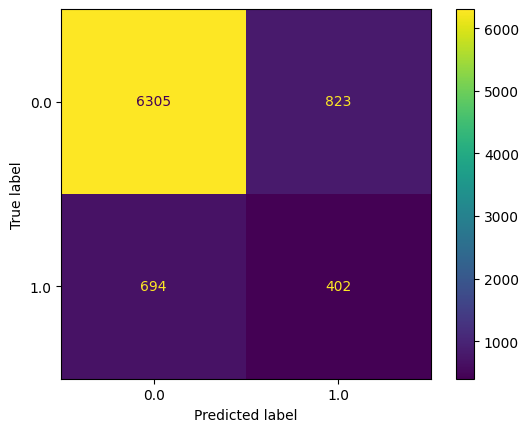

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_smote, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_smote.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.8845398428731762
F1 Score: 0.892616974587669




---



In [ ]:
model_names = ['model_reg','model_under', 'model_over', 'model_smote']
roc_auc_scores = [0.6345731237762868, 0.5, 0.4438592125635921, 0.6256640820205297]
accuracy_scores = [0.7923, 0.659, 0.8279, 0.4005]
Precision= [0.9005331088664422,0.0,0.09848484848484848, 0.8845398428731762]
F1_Score= [0.9016082590069527,'nan',0.1741719389653889, 0.892616974587669]
# Create a dictionary using the variables
data = {'Model': model_names,
        'ROC AUC': roc_auc_scores,
        'Accuracy': accuracy_scores,
        'Precision': Precision,
        'F1 Score': F1_Score}

Table = pd.DataFrame(data)
table = tabulate(Table, headers='keys', tablefmt='psql')
print(table)

+----+-------------+-----------+------------+-------------+------------+
|    | Model       |   ROC AUC |   Accuracy |   Precision |   F1 Score |
|----+-------------+-----------+------------+-------------+------------|
|  0 | model_reg   |  0.634573 |     0.7923 |   0.900533  |   0.901608 |
|  1 | model_under |  0.5      |     0.659  |   0         | nan        |
|  2 | model_over  |  0.443859 |     0.8279 |   0.0984848 |   0.174172 |
|  3 | model_smote |  0.625664 |     0.4005 |   0.88454   |   0.892617 |
+----+-------------+-----------+------------+-------------+------------+


**Analysis:**


---


**model_reg**:High ROC AUC (0.634573): Indicates a good ability to discriminate between the classes, suggesting it can effectively distinguish between positive and negative instances.
Good Accuracy (0.7923): Shows a strong overall performance in terms of correct predictions, suggesting it generalizes well to unseen data.
Very High Precision (0.900533): Indicates a very low false-positive rate. This means the model is very cautious about predicting a positive instance, minimizing incorrect positive predictions.
Excellent F1-Score (0.901608): Demonstrates a good balance between precision and recall. This metric is particularly important for imbalanced datasets as it considers both the ability to correctly identify positive instances (recall) and the ability to minimize false positives (precision).

**model_under** is clearly the worst performer with a ROC AUC of 0.5 (equivalent to random guessing), zero precision, and an undefined F1-score. This suggests the undersampling technique might have removed too much crucial information.

**model_over** shows decent accuracy but suffers from very low precision and a low F1-score, indicating a high false-positive rate. This might be due to overfitting caused by the oversampling technique.

**model_smote** presents a mixed picture with a reasonable ROC AUC, very high precision, but low accuracy. Its high F1-score suggests a good balance between precision and recall, but the low accuracy raises concerns about its overall performance.


---


**Conclusion**
**model_reg** emerges as the most promising candidate based on the available metrics.

 Saving best model.

In [ ]:
with open('best-dtc-class.pkl', 'wb') as f:
    dill.dump(model_reg, f)



---


---




## c) Random forest classifier.



---
AS well these params used where tuned with GridSearch.

 Oversampled data.

In [ ]:
model_rfc1 = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [4]
}


model_rfc1.fit(X_train_scaled_over, y_train_over)
accuracies = cross_val_score(model_rfc1, X_train_scaled_over, y_train_over, cv=5)


# Predict on test data using the best model
y_pred = model_rfc1.predict(X_test_scaled_over)

# Evaluate accuracy on test data
accuracy = model_rfc1.score(X_test_scaled_over, y_test)
y_pred_proba = model_smote.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test Accuracy:", accuracy)
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)

Test Accuracy: 0.8898346303501945
Train Score: 0.9910611083785247
Best ROC AUC Score: 0.6256640820205297


(0.0, 1.05)

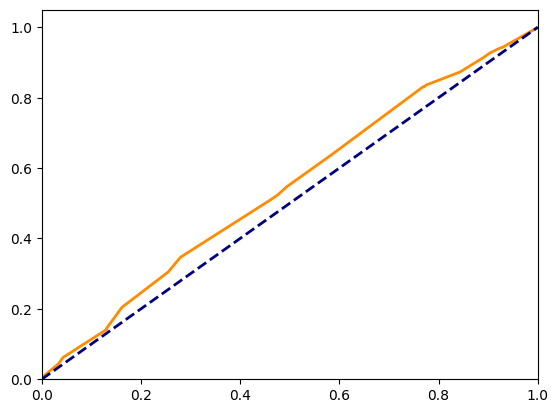

In [ ]:
y_pred_proba = model_rfc1.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

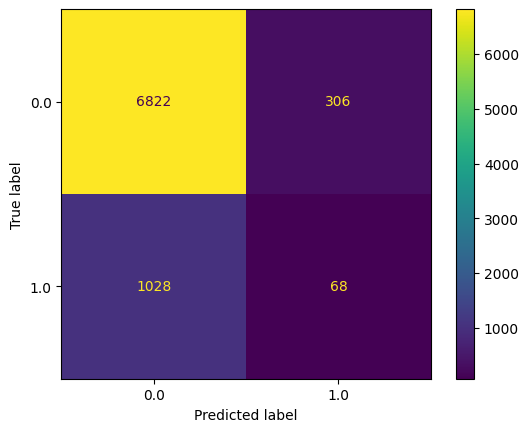

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_rfc1, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_rfc1.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.9570707070707071
F1 Score: 0.9109360395246361


Undersampled data model.

In [ ]:
model_rfc2 = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [4]
}


model_rfc2.fit(X_train_scaled_under,y_train_under)
accuracies = cross_val_score(model_rfc2, X_train_scaled_under, y_train_under, cv=5)



# Predict on test data using the best model
y_pred = model_rfc2.predict(X_train_scaled_under)

# Evaluate accuracy on test data
accuracy = model_rfc2.score(X_test_under, y_test)
y_pred_proba = model_rfc2.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test Accuracy:", accuracy)
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)

Test Accuracy: 0.7535262645914397
Train Score: 0.7038410974528957
Best ROC AUC Score: 0.5377311998738398


(0.0, 1.05)

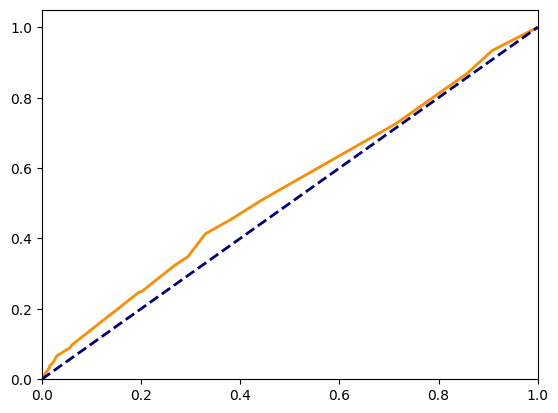

In [ ]:
y_pred_proba = model_rfc2.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

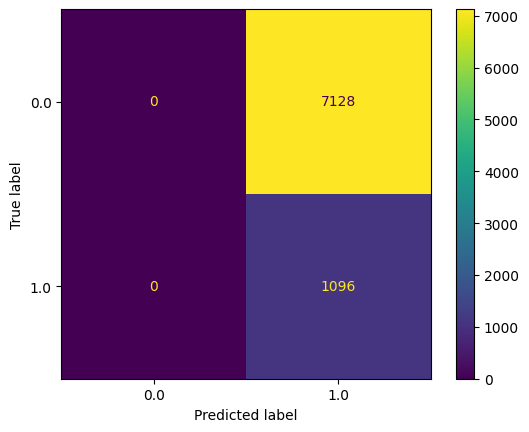

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_rfc2, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_rfc2.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.0
F1 Score: nan


<ipython-input-170-8a63f320381f>:20: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)









---



>With Smote.

In [ ]:
model_rfc3 = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [4]
}


model_rfc3.fit(X_train_smote,y_train_over)
accuracies = cross_val_score(model_rfc3, X_train_smote, y_train_over, cv=5)



# Predict on test data using the best model
y_pred = model_rfc3.predict(X_train_smote)

# Evaluate accuracy on test data
accuracy = model_rfc3.score(X_test_smote, y_test)
y_pred_proba = model_rfc3.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test Accuracy:", accuracy)
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)

Test Accuracy: 0.8872811284046692
Train Score: 0.9214044674002573
Best ROC AUC Score: 0.49996364701352536


(0.0, 1.05)

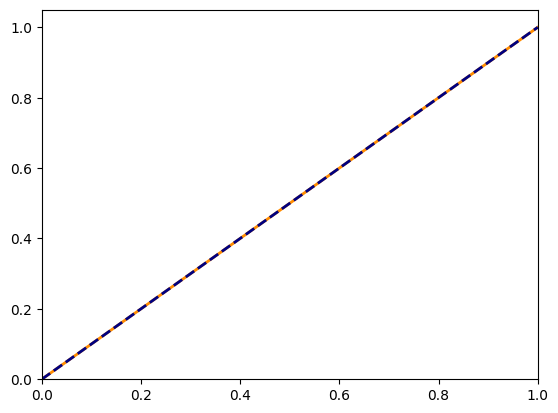

In [ ]:
y_pred_proba = model_rfc3.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

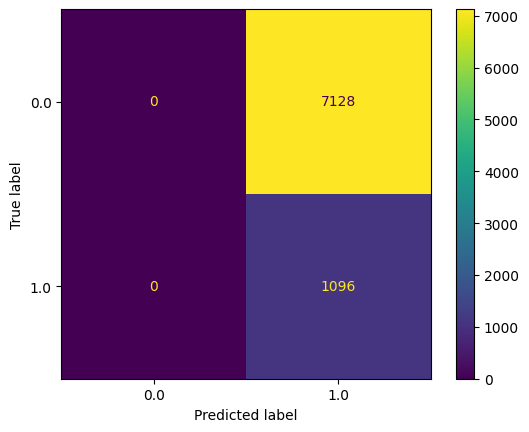

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_rfc3, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_rfc3.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.0
F1 Score: nan


<ipython-input-174-a0c9c49ec69b>:20: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)




---



>With raw data.

In [ ]:
model_rfc4 = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [4]
}


model_rfc4.fit(X_train,y_train)
accuracies = cross_val_score(model_rfc4, X_train, y_train, cv=5)



# Predict on test data using the best model
y_pred = model_rfc4.predict(X_train)

# Evaluate accuracy on test data
accuracy = model_rfc4.score(X_test, y_test)
y_pred_proba = model_rfc4.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test Accuracy:", accuracy)
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)

Test Accuracy: 0.8891050583657587
Train Score: 0.8866879203933469
Best ROC AUC Score: 0.7830108797832338


(0.0, 1.05)

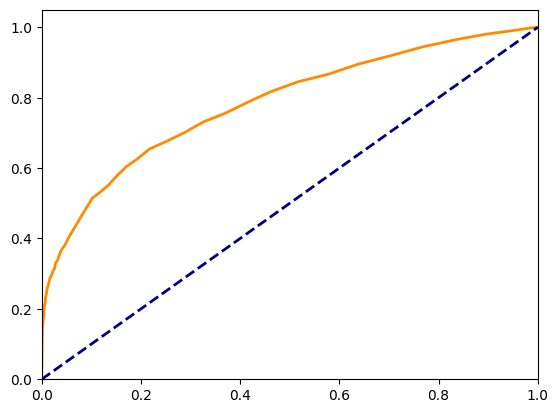

In [ ]:
y_pred_proba = model_rfc4.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

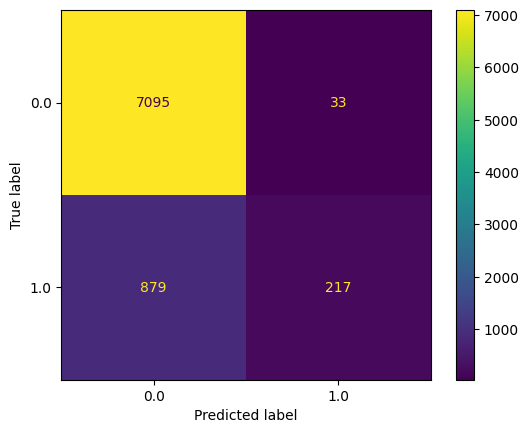

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_rfc4, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, model_rfc4.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.9953703703703703
F1 Score: 0.9396106475963449




---



In [ ]:
model_names = ['model_rfc1','model_rfc2', 'model_rfc3', 'model_rfc4']
roc_auc_scores = [0.6256640820205297, 0.5377311998738398, 0.49996364701352536, 0.7830108797832338]
accuracy_scores = [0.8898346303501945, 0.7535262645914397, 0.8872811284046692, 0.8891050583657587]
Precision = [0.9570707070707071,0.0,0.0,0.9953703703703703]
F1_Score = [0.9109360395246361,'nan','nan',0.9396106475963449]
# Create a dictionary using the variables
data = {'Model': model_names,
        'ROC AUC': roc_auc_scores,
        'Accuracy': accuracy_scores,
        'Precision':Precision,
        'F1_Score': F1_Score}

Table = pd.DataFrame(data)
table = tabulate(Table, headers='keys', tablefmt='psql')
print(table)

+----+------------+-----------+------------+-------------+------------+
|    | Model      |   ROC AUC |   Accuracy |   Precision |   F1_Score |
|----+------------+-----------+------------+-------------+------------|
|  0 | model_rfc1 |  0.625664 |   0.889835 |    0.957071 |   0.910936 |
|  1 | model_rfc2 |  0.537731 |   0.753526 |    0        | nan        |
|  2 | model_rfc3 |  0.499964 |   0.887281 |    0        | nan        |
|  3 | model_rfc4 |  0.783011 |   0.889105 |    0.99537  |   0.939611 |
+----+------------+-----------+------------+-------------+------------+


**Analysis:**


---


**model_rfc1**:
ROC AUC: 0.625664 (Decent discriminatory power)
Accuracy: 0.889835 (High overall correctness)
Precision: 0.957071 (Very high, minimizing false positives)
F1-Score: 0.910936 (Good balance between precision and recall)
Summary: A strong all-around performer, suitable for scenarios where minimizing false positives is important.

**model_rfc2**:ROC AUC: 0.537731 (Barely better than random chance)
Accuracy: 0.753526 (Moderate overall correctness)
Precision: 0.0 (Severe issue, likely many false positives)
F1-Score: 'nan' (Undefined due to zero precision)
Summary: Exhibits poor performance, likely due to a high false-positive rate, and should be reconsidered or significantly improved.

**model_rfc3**:ROC AUC: 0.499964 (Worse than random guessing)
Accuracy: 0.887281 (High overall correctness, but misleading)
Precision: 0.0 (Severe issue, likely many false positives)
F1-Score: 'nan' (Undefined due to zero precision)
Summary: Performs poorly, even worse than random chance, indicating fundamental issues with the model.

**model_rfc4**:
High ROC AUC (0.783011): Indicates excellent discriminatory power, effectively distinguishing between classes.
High Accuracy (0.889105): Shows strong overall correct predictions.
Extremely High Precision (0.995370): Signifies an extremely low false-positive rate, crucial for minimizing misclassifications, especially when the cost of false positives is high.
High F1-Score (0.939611): Confirms a good balance between precision and recall, important for overall model performance.


---


**Recommendation**: model_rfc4 stands out as the most reliable choice for scenarios where minimizing false positives is a priority, while maintaining a good balance between precision and recall.

Saving better model.

In [ ]:
with open('best-rfc-class.pkl', 'wb') as f:
  dill.dump(model_rfc4, f)



---



---



## d) K-Nearest Neighbors.



---


>GridSearch also used to fine tune these params.

>Oversampled data.

---



In [ ]:
knn1 = Pipeline([
    ('scaler', FunctionTransformer(lambda x:x)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform'],
    'knn__p': [2]  # 1 for Manhattan distance, 2 for Euclidean distance
}


# Fit the grid search to the oversampled training data
knn1.fit(X_train_scaled_over, y_train_over)
accuracies = cross_val_score(knn1, X_train_scaled_over, y_train_over, cv=5)


# Predict
y_pred = knn1.predict(X_test)
y_pred_proba = knn1.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
accuracy = knn1.score(X_test_scaled_over, y_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn1.score(X_test_scaled_over,y_test))
print("Best ROC AUC Score:", roc_auc)

Train Score: 0.8439719333662323
Test Score: 0.7213035019455253
Best ROC AUC Score: 0.4092392651166982


(0.0, 1.05)

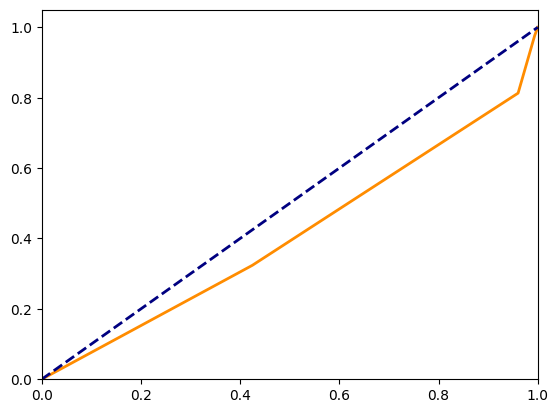

In [ ]:
y_pred_proba = knn1.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

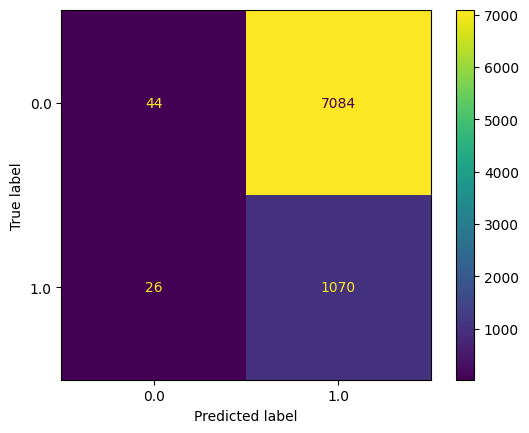

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(knn1, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, knn1.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.006172839506172839
F1 Score: 0.012225618227285356




---



>Undersampled data.


---



In [ ]:
knn2 = Pipeline([
    ('scaler', FunctionTransformer(lambda x:x)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform'],
    'knn__p': [2]  # 1 for Manhattan distance, 2 for Euclidean distance
}


# Fit the grid search to the oversampled training data
knn2.fit(X_train_scaled_under,y_train_under)
accuracies = cross_val_score(knn2, X_train_scaled_under, y_train_under, cv=5)


# Predict
y_pred = knn2.predict(X_test)
y_pred_proba = knn2.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
accuracy = knn2.score(X_test_under, y_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn2.score(X_test_under,y_test))
print("Best ROC AUC Score:", roc_auc)

Train Score: 0.5963366092110118
Test Score: 0.6607490272373541
Best ROC AUC Score: 0.4163103049964364


(0.0, 1.05)

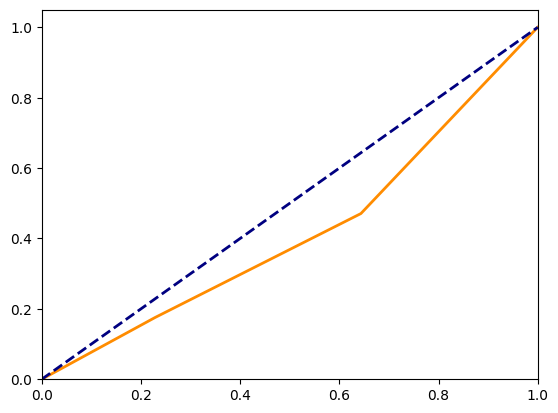

In [ ]:
y_pred_proba = knn2.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

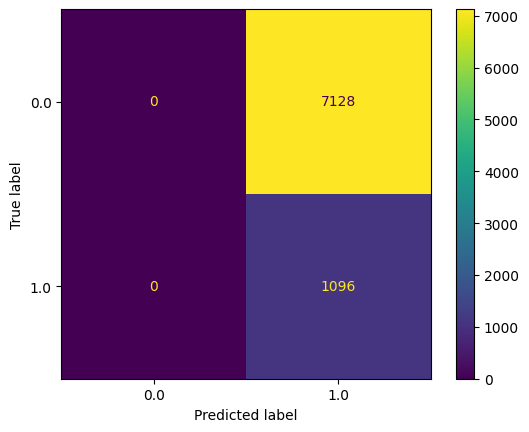

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(knn2, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, knn2.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.0
F1 Score: nan


<ipython-input-192-26999fd8660d>:20: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)




---



>Smote data.

In [ ]:
knn3 = Pipeline([
    ('scaler', FunctionTransformer(lambda x:x)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform'],
    'knn__p': [2]  # 1 for Manhattan distance, 2 for Euclidean distance
}


# Fit the grid search to the oversampled training data
knn3.fit(X_train_smote,y_resampled)
accuracies = cross_val_score(knn3, X_train_smote, y_resampled, cv=5)


# Predict
y_pred = knn3.predict(X_test)
y_pred_proba = knn3.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
accuracy = knn3.score(X_test_smote, y_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn3.score(X_test_smote,y_test))
print("Best ROC AUC Score:", roc_auc)

Train Score: 0.8638209256433458
Test Score: 0.8252675097276264
Best ROC AUC Score: 0.424112116706399


(0.0, 1.05)

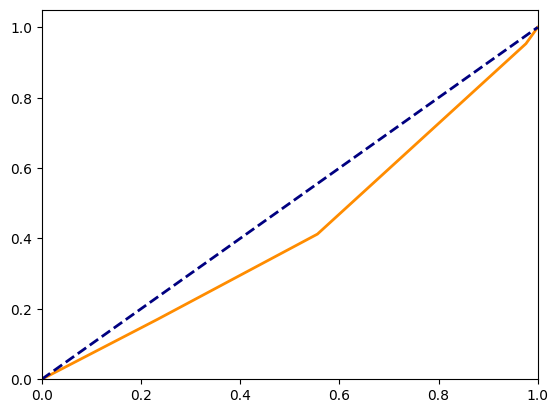

In [ ]:
y_pred_proba = knn3.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

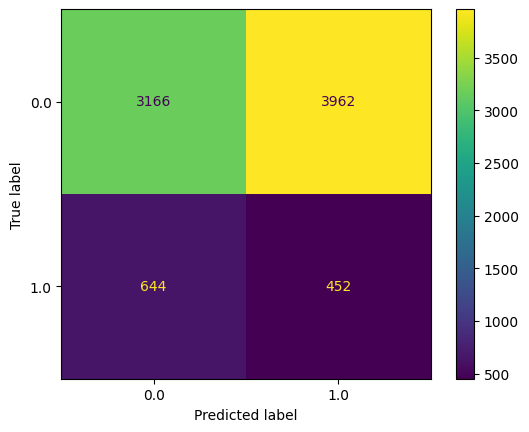

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(knn3, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, knn3.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.4441638608305275
F1 Score: 0.5788992503199855




---



>Raw data.

In [ ]:
# raw data model knn4
knn4 = Pipeline([
    ('scaler', FunctionTransformer(lambda x:x)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform'],
    'knn__p': [2]  # 1 for Manhattan distance, 2 for Euclidean distance
}


# Fit the grid search
knn4.fit(X_train,y_train)
accuracies = cross_val_score(knn4, X_train, y_train, cv=5)


# Predict
y_pred = knn4.predict(X_test)
y_pred_proba = knn4.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
accuracy = knn4.score(X_test, y_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn4.score(X_test,y_test))
print("Best ROC AUC Score:", roc_auc)

Train Score: 0.8535563449195257
Test Score: 0.8580982490272373
Best ROC AUC Score: 0.5813943367167211


(0.0, 1.05)

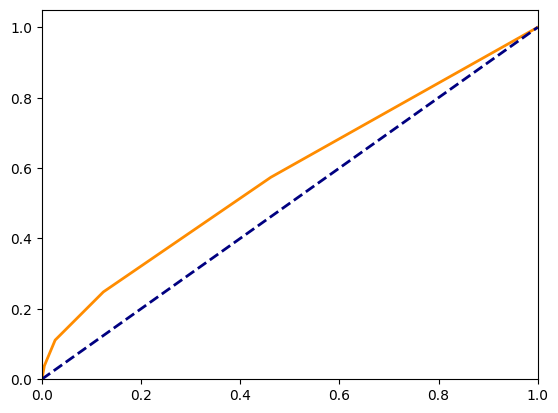

In [ ]:
y_pred_proba = knn4.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

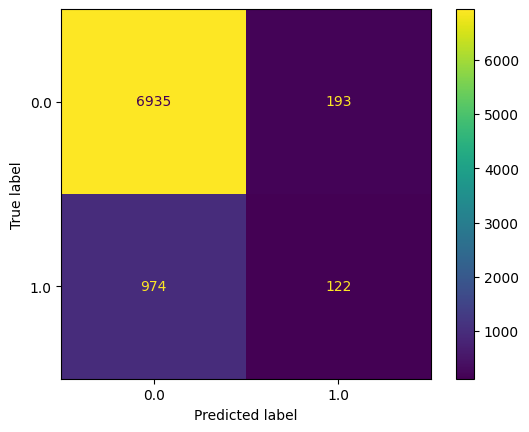

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(knn4, X_test, y_test)

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, knn4.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.9729236812570146
F1 Score: 0.9223914344616612




---



>Saving best of the model in peformance

In [ ]:
model_names = ['knn1','knn2', 'knn3', 'knn4']
roc_auc_scores = [0.4092392651166982, 0.4163103049964364, 0.424112116706399, 0.5813943367167211]
accuracy_scores = [0.7213035019455253,  0.6607490272373541,  0.8252675097276264, 0.8580982490272373]
Precision = [0.006172839506172839,0.0,0.4441638608305275,0.9729236812570146]
F1_Score = [0.012225618227285356,'nan',0.5788992503199855,0.9223914344616612]
# Create a dictionary using the variables
data = {'Model': model_names,
        'ROC AUC': roc_auc_scores,
        'Accuracy': accuracy_scores,
        'Precision':Precision,
        'F1_Score':F1_Score}

Table = pd.DataFrame(data)
table = tabulate(Table, headers='keys', tablefmt='psql')
print(table)

+----+---------+-----------+------------+-------------+-------------+
|    | Model   |   ROC AUC |   Accuracy |   Precision |    F1_Score |
|----+---------+-----------+------------+-------------+-------------|
|  0 | knn1    |  0.409239 |   0.721304 |  0.00617284 |   0.0122256 |
|  1 | knn2    |  0.41631  |   0.660749 |  0          | nan         |
|  2 | knn3    |  0.424112 |   0.825268 |  0.444164   |   0.578899  |
|  3 | knn4    |  0.581394 |   0.858098 |  0.972924   |   0.922391  |
+----+---------+-----------+------------+-------------+-------------+




---



**Analysis:**

**knn1**:

ROC AUC: 0.409239 (Very poor, worse than random chance)
Accuracy: 0.721304 (Moderate, but misleading given low ROC AUC)
Precision: 0.006173 (Extremely low, indicating a high false-positive rate)
F1-Score: 0.012226 (Very low, reflecting poor overall performance)
Summary: Exhibits extremely poor performance across all metrics, suggesting fundamental issues with the model or data.

**knn2**:

ROC AUC: 0.416310 (Very poor, worse than random chance)
Accuracy: 0.660749 (Low overall correctness)
Precision: 0.0 (Severe issue, likely many false positives)
F1-Score: 'nan' (Undefined due to zero precision)
Summary: Performs poorly, similar to knn1, indicating significant room for improvement.

**knn3**:

ROC AUC: 0.424112 (Very poor, slightly better than random chance)
Accuracy: 0.825268 (High, but misleading given low ROC AUC)
Precision: 0.444164 (Moderate, some success in minimizing false positives)
F1-Score: 0.578899 (Moderate, reflecting a balance between precision and recall)
Summary: Shows some improvement over knn1 and knn2, but still suffers from a low ROC AUC, indicating limited discriminatory power.

**knn4**:

ROC AUC: 0.581394 (Moderate discriminatory power)
Accuracy: 0.858098 (High overall correctness)
Precision: 0.972924 (Very high, excellent at minimizing false positives)
F1-Score: 0.922391 (High, indicating a good balance between precision and recall)
Summary: Clearly the best performing model among the KNN variants, demonstrating good discriminatory power, high accuracy, and a strong focus on minimizing false positives.

**Key Observations.**

Poor Performance of knn1, knn2, and knn3: These models exhibit very low ROC AUC scores, indicating they struggle to effectively distinguish between classes.
Strength of knn4: knn4 stands out with a significantly better ROC AUC, high accuracy, and excellent precision, suggesting it's the most suitable model among the options.
Recommendations

Focus on knn4: Further optimize knn4 through hyperparameter

In [ ]:
with open('best-knn-class.pkl', 'wb') as f:
    dill.dump(knn4, f)



---



---



## e) Multi-Layer Perceptron Neural Network.

>GridSearch was applied to these models to come with these params.

>Raw data.



---



In [ ]:
# Define the model

model = Sequential()
# Assuming X_train and y_train are already defined
input_dim = X_train.shape[1]  # Number of features
model.add(Dense(182, activation='relu', input_dim=input_dim))
model.add(BatchNormalization())
model.add(Dense(91, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(111, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(80, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Perform manual cross-validation
accuracies = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Adjust n_splits as needed
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]


    history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,  # Adjust as needed
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )
    _, accuracye = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(accuracye)

# Evaluate the model
losse, accuracye = model.evaluate(X_test, y_test)
print("Loss:", losse)
print("Accuracy:", accuracye)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)


Epoch 1/10
1851/1851 [==============================] - 13s 5ms/step - loss: 0.3950 - accuracy: 0.8632 - val_loss: 0.3881 - val_accuracy: 0.8631
Epoch 2/10
1851/1851 [==============================] - 14s 8ms/step - loss: 0.3869 - accuracy: 0.8638 - val_loss: 0.3801 - val_accuracy: 0.8600
Epoch 3/10
1851/1851 [==============================] - 12s 7ms/step - loss: 0.3866 - accuracy: 0.8638 - val_loss: 0.3812 - val_accuracy: 0.8639
Epoch 4/10
1851/1851 [==============================] - 9s 5ms/step - loss: 0.3855 - accuracy: 0.8637 - val_loss: 0.3788 - val_accuracy: 0.8639
Epoch 5/10
1851/1851 [==============================] - 10s 5ms/step - loss: 0.3833 - accuracy: 0.8639 - val_loss: 0.3785 - val_accuracy: 0.8639
Epoch 6/10
1851/1851 [==============================] - 11s 6ms/step - loss: 0.3824 - accuracy: 0.8636 - val_loss: 0.3804 - val_accuracy: 0.8639
Epoch 7/10
463/463 [==============================] - 1s 2ms/step - loss: 0.3794 - accuracy: 0.8639
Epoch 1/10
1851/1851 [=========

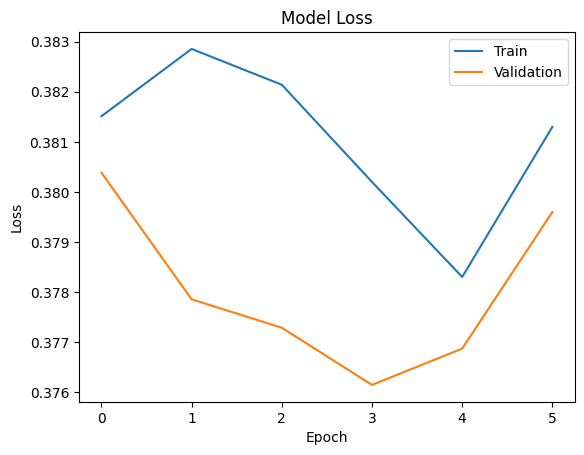

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

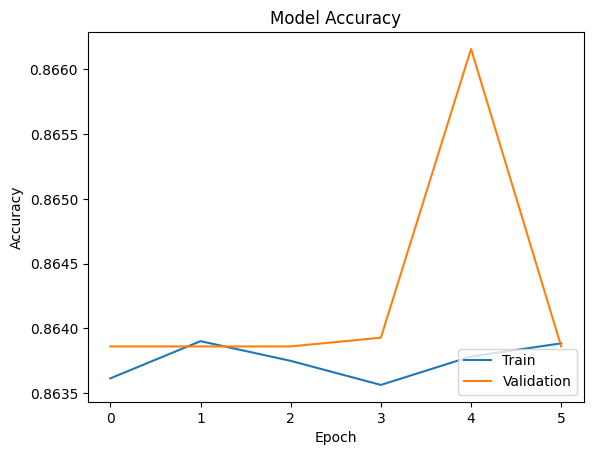

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

257/257 [==============================] - 1s 3ms/step


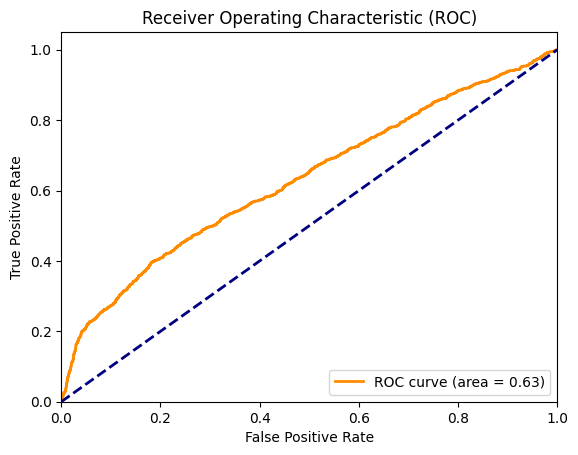

In [ ]:
y_pred_proba = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

257/257 [==============================] - 1s 2ms/step


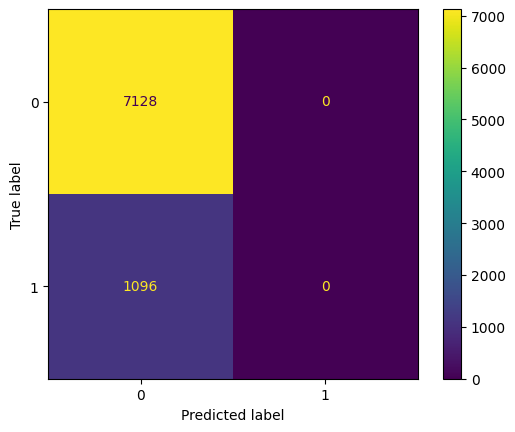

In [ ]:
# Predict class labels
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 1.0
F1 Score: 0.9286086503387181




---



>Oversampled data

In [ ]:
# oversampled data

# Define the model

model = Sequential()
# Assuming X_train and y_train are already defined
input_dim = 182  # Number of features
model.add(Dense(182, activation='relu', input_dim=input_dim))
model.add(BatchNormalization())
model.add(Dense(91, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(111, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(80, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Perform manual cross-validation
accuracies = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Adjust n_splits as needed
for train_index, val_index in kf.split(X_train_scaled_over,y_train_over):
    X_train_fold, X_val_fold = X_train_scaled_over.iloc[train_index], X_train_scaled_over.iloc[val_index]
    y_train_fold, y_val_fold = y_train_over.iloc[train_index], y_train_over.iloc[val_index]


    history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,  # Adjust as needed
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )
    _, accuracye = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(accuracye)

# Evaluate the model
losse, accuracye = model.evaluate(X_test, y_test)
print("Loss:", losse)
print("Accuracy:", accuracye)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)


Epoch 1/10
3197/3197 [==============================] - 23s 6ms/step - loss: 0.6281 - accuracy: 0.6368 - val_loss: 0.5936 - val_accuracy: 0.6686
Epoch 2/10
3197/3197 [==============================] - 33s 10ms/step - loss: 0.5915 - accuracy: 0.6766 - val_loss: 0.5697 - val_accuracy: 0.7045
Epoch 3/10
3197/3197 [==============================] - 32s 10ms/step - loss: 0.5628 - accuracy: 0.7039 - val_loss: 0.5673 - val_accuracy: 0.7204
Epoch 4/10
3197/3197 [==============================] - 18s 6ms/step - loss: 0.5466 - accuracy: 0.7158 - val_loss: 0.5471 - val_accuracy: 0.7302
Epoch 5/10
3197/3197 [==============================] - 19s 6ms/step - loss: 0.5356 - accuracy: 0.7243 - val_loss: 0.5300 - val_accuracy: 0.7440
Epoch 6/10
3197/3197 [==============================] - 19s 6ms/step - loss: 0.5283 - accuracy: 0.7324 - val_loss: 0.5254 - val_accuracy: 0.7445
Epoch 7/10
3197/3197 [==============================] - 20s 6ms/step - loss: 0.5211 - accuracy: 0.7369 - val_loss: 0.5395 - val_

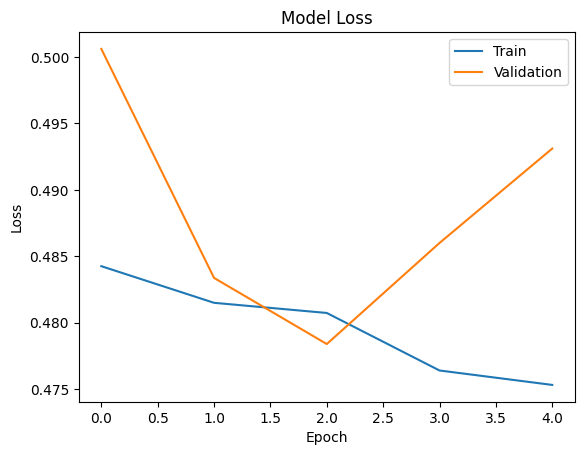

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

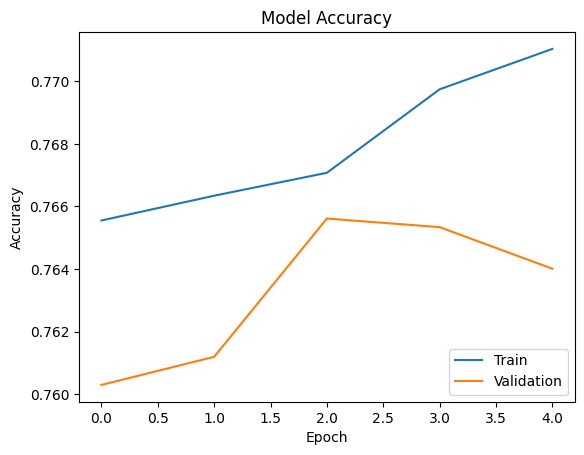

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

257/257 [==============================] - 1s 2ms/step


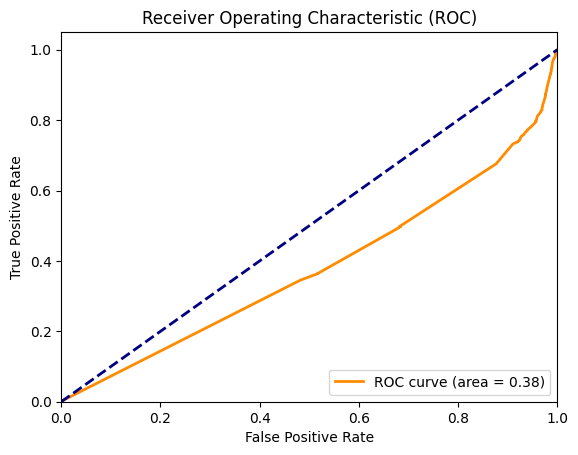

In [ ]:
y_pred_proba = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

257/257 [==============================] - 1s 2ms/step


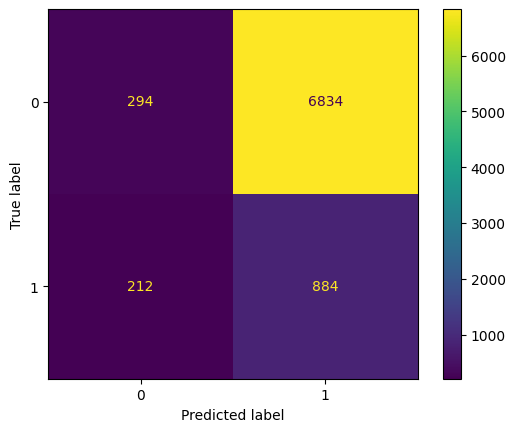

In [ ]:
# Predict class labels
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.041245791245791245
F1 Score: 0.07702384071260152




---



> Undersampled data

In [ ]:
# undersampled data

# Define the model

model = Sequential()
# Assuming X_train and y_train are already defined
input_dim = X_train_scaled_under.shape[1]  # Number of features
model.add(Dense(182, activation='relu', input_dim=input_dim))
model.add(BatchNormalization())
model.add(Dense(91, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(111, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(80, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Perform manual cross-validation
accuracies = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Adjust n_splits as needed
for train_index, val_index in kf.split(X_train_scaled_under,y_train_under):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]


    history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,  # Adjust as needed
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )
    _, accuracye = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(accuracye)

# Evaluate the model
losse, accuracye = model.evaluate(X_test, y_test)
print("Loss:", losse)
print("Accuracy:", accuracye)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)


Epoch 1/10
504/504 [==============================] - 12s 15ms/step - loss: 0.4086 - accuracy: 0.8605 - val_loss: 0.4005 - val_accuracy: 0.8682
Epoch 2/10
504/504 [==============================] - 4s 9ms/step - loss: 0.3949 - accuracy: 0.8618 - val_loss: 0.3788 - val_accuracy: 0.8687
Epoch 3/10
504/504 [==============================] - 5s 9ms/step - loss: 0.3955 - accuracy: 0.8618 - val_loss: 0.3981 - val_accuracy: 0.8479
Epoch 4/10
126/126 [==============================] - 1s 6ms/step - loss: 0.3818 - accuracy: 0.8687
Epoch 1/10
504/504 [==============================] - 7s 13ms/step - loss: 0.3857 - accuracy: 0.8638 - val_loss: 0.3928 - val_accuracy: 0.8586
Epoch 2/10
504/504 [==============================] - 7s 15ms/step - loss: 0.3844 - accuracy: 0.8639 - val_loss: 0.3985 - val_accuracy: 0.8432
Epoch 3/10
126/126 [==============================] - 0s 3ms/step - loss: 0.3940 - accuracy: 0.8586
Epoch 1/10
504/504 [==============================] - 4s 8ms/step - loss: 0.3882 - acc

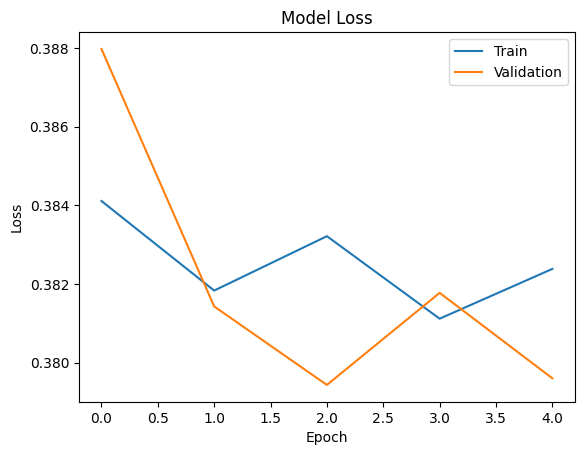

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

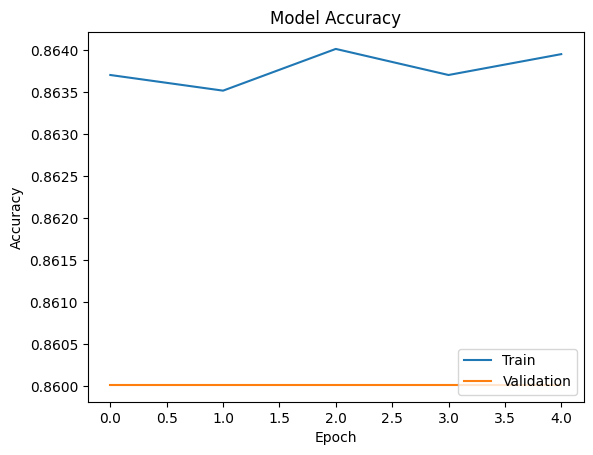

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

257/257 [==============================] - 1s 2ms/step


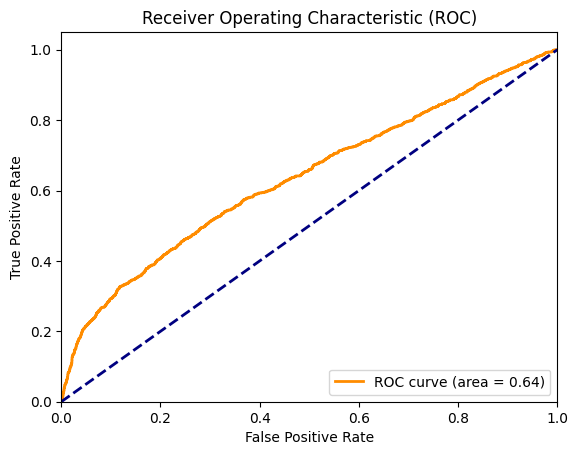

In [ ]:
y_pred_proba = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

257/257 [==============================] - 1s 2ms/step


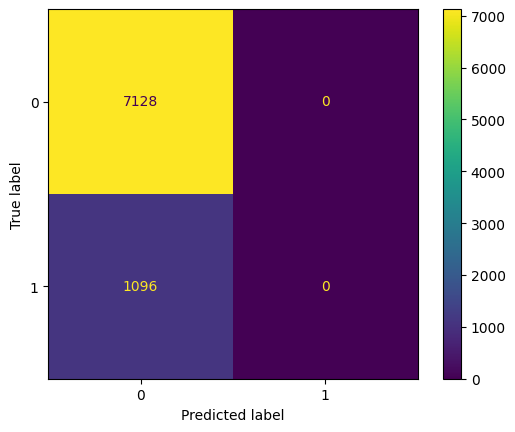

In [ ]:
# Predict class labels
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 1.0
F1 Score: 0.9286086503387181




---



>Smote data.

In [ ]:
# smote data
# Define the model

model = Sequential()
# Assuming X_train and y_train are already defined
input_dim = X_train_smote.shape[1]  # Number of features
model.add(Dense(182, activation='relu', input_dim=input_dim))
model.add(BatchNormalization())
model.add(Dense(91, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(111, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(80, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Perform manual cross-validation
accuracies = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Adjust n_splits as needed
for train_index, val_index in kf.split(X_train_smote,y_resampled):
    X_train_fold, X_val_fold = X_train_smote.iloc[train_index], X_train_smote.iloc[val_index]
    y_train_fold, y_val_fold = y_resampled.iloc[train_index], y_resampled.iloc[val_index]


    history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,  # Adjust as needed
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping]
    )
    _, accuracye = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(accuracye)

# Evaluate the model
losse, accuracye = model.evaluate(X_test, y_test)
print("Loss:", losse)
print("Accuracy:", accuracye)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate accuracy on test data
print("Train Score:",np.mean(accuracies))
print("Best ROC AUC Score:", roc_auc)


Epoch 1/10
3197/3197 [==============================] - 33s 9ms/step - loss: 0.4992 - accuracy: 0.7519 - val_loss: 0.4600 - val_accuracy: 0.7662
Epoch 2/10
3197/3197 [==============================] - 36s 11ms/step - loss: 0.3997 - accuracy: 0.8219 - val_loss: 0.3349 - val_accuracy: 0.8669
Epoch 3/10
3197/3197 [==============================] - 38s 12ms/step - loss: 0.3672 - accuracy: 0.8405 - val_loss: 0.4379 - val_accuracy: 0.7537
Epoch 4/10
800/800 [==============================] - 3s 3ms/step - loss: 0.4266 - accuracy: 0.7560
Epoch 1/10
3197/3197 [==============================] - 19s 6ms/step - loss: 0.3305 - accuracy: 0.8618 - val_loss: 0.3821 - val_accuracy: 0.8097
Epoch 2/10
3197/3197 [==============================] - 17s 5ms/step - loss: 0.3206 - accuracy: 0.8675 - val_loss: 0.4304 - val_accuracy: 0.7625
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.4004 - accuracy: 0.8028
Epoch 1/10
3197/3197 [==============================] - 18s 6ms/step - lo

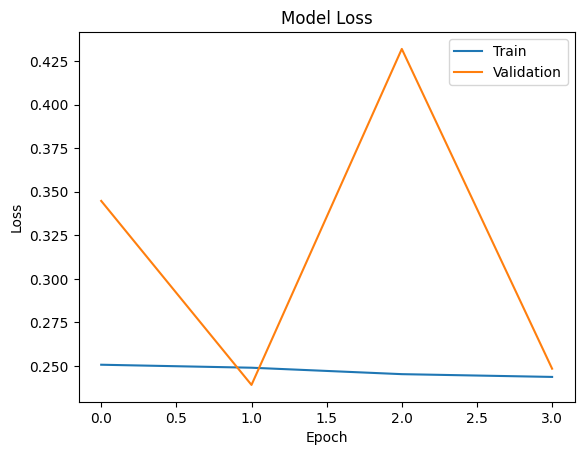

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

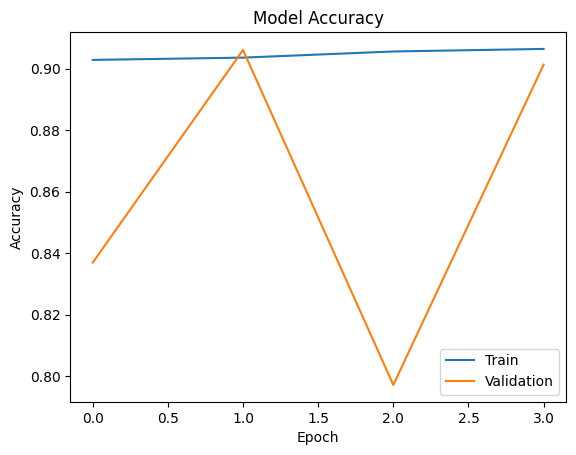

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

257/257 [==============================] - 0s 2ms/step


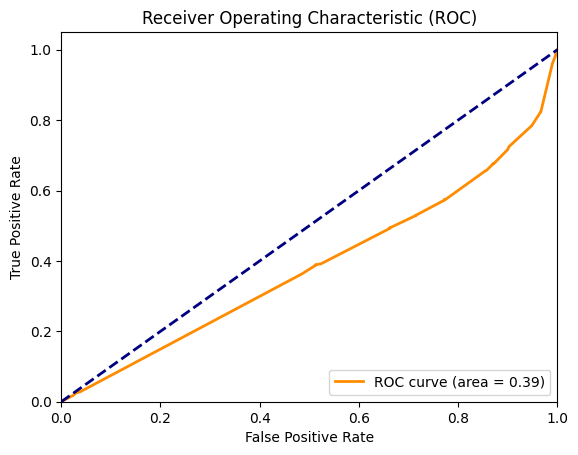

In [ ]:
y_pred_proba = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

257/257 [==============================] - 1s 2ms/step


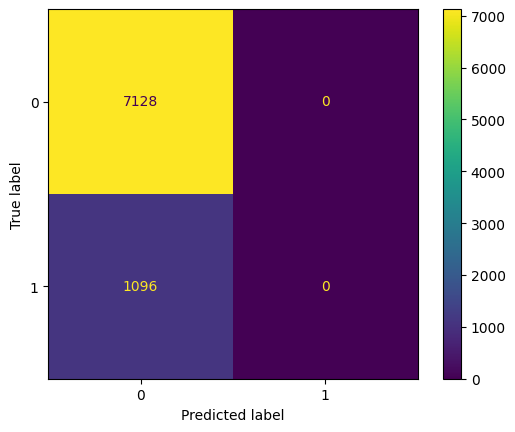

In [ ]:
# Predict class labels
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 1.0
F1 Score: 0.9286086503387181




---



Saving best model.

In [ ]:
model_names = ['model_1','model_2', 'model_3', 'model_4']
roc_auc_scores = [ 0.6441948888725044, 0.3791044313778499, 0.6288817693356927, 0.6288817693356927]
accuracy_scores = [0.8638795733451843,  0.7555059552192688, 0.86296392679214472, 0.8629639267921447]
Precision = [ 1.0,0.041245791245791245,1.0,1.0]
F1_Score = [0.9286086503387181,0.07702384071260152,0.9286086503387181,0.9286086503387181]
# Create a dictionary using the variables
data = {'Model': model_names,
        'ROC AUC': roc_auc_scores,
        'Accuracy': accuracy_scores,
        'Precision':Precision,
        'F1_Score':F1_Score}

Table = pd.DataFrame(data)
table = tabulate(Table, headers='keys', tablefmt='psql')
print(table)

+----+---------+-----------+------------+-------------+------------+
|    | Model   |   ROC AUC |   Accuracy |   Precision |   F1_Score |
|----+---------+-----------+------------+-------------+------------|
|  0 | model_1 |  0.644195 |   0.86388  |   1         |  0.928609  |
|  1 | model_2 |  0.379104 |   0.755506 |   0.0412458 |  0.0770238 |
|  2 | model_3 |  0.628882 |   0.862964 |   1         |  0.928609  |
|  3 | model_4 |  0.628882 |   0.862964 |   1         |  0.928609  |
+----+---------+-----------+------------+-------------+------------+


**Analysis:**


---


**model_1**:

ROC AUC: 0.644195 (Decent discriminatory power)
Accuracy: 0.863880 (High overall correctness)
Precision: 1.0 (Perfect precision, no false positives)
F1-Score: 0.928609 (High, indicating a good balance, but slightly lower due to perfect precision)

**Summary**: A strong performer with excellent precision, minimizing false positives. However, the perfect precision suggests potential overfitting or a very specific dataset characteristic.

**model_2**:

ROC AUC: 0.379104 (Very poor, significantly worse than random chance)
Accuracy: 0.755506 (Moderate, but misleading given the low ROC AUC)
Precision: 0.041246 (Extremely low, indicating a high false-positive rate)
F1-Score: 0.077024 (Very low, reflecting poor overall performance)
**Summary**: Exhibits very poor performance, especially in terms of discriminatory power and precision. This model requires significant improvement or reconsideration.

**model_3**:

ROC AUC: 0.628882 (Decent discriminatory power)
Accuracy: 0.862964 (High overall correctness)
Precision: 1.0 (Perfect precision, no false positives)
F1-Score: 0.928609 (High, indicating a good balance, but slightly lower due to perfect precision)
**Summary**: Similar to model_1, it demonstrates strong performance with perfect precision. However, the same concerns about potential overfitting or dataset characteristics apply.

**model_4**:

ROC AUC: 0.628882 (Decent discriminatory power)
Accuracy: 0.862964 (High overall correctness)
Precision: 1.0 (Perfect precision, no false positives)
F1-Score: 0.928609 ( high)
**Summary**: Appears very similar to model_1 and model_3, with the same strengths and potential concerns.



   

---



---



## f.)Stacking models.

In [ ]:
base_models = [
    ('xgboost', best_modelxg),
     ('random_forest', best_modelrfc)
     ]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluate performance
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print("Stacking Model Metrics:")
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

Stacking Model Metrics:
ROC AUC: 0.6609387672343877
Accuracy: 0.8994406614785992


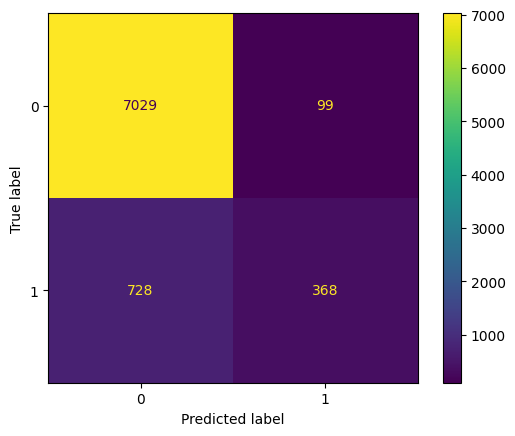

In [ ]:
# Predict class labels
y_pred = (stacking_clf.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.9861111111111112
F1 Score: 0.9444407121263015


In [ ]:
with open("best-xgb-class.pkl", "rb") as f:
  best_modelxg= dill.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'best-xgb-class.pkl'

In [ ]:
with open("best-rfc-class.pkl", "rb") as f:
  best_modelrfc= dill.load(f)



---



>Oversampled data.

In [ ]:
base_models = [
    ('xgboost', best_modelxg),
     ('random_forest', best_modelrfc)
     ]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluate performance
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print("Stacking Model Metrics:")
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

In [ ]:
# Predict class labels
y_pred = (stacking_clf.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)



---



>Undersampled data

In [ ]:
base_models = [
    ('xgboost', best_modelxg),
     ('random_forest', best_modelrfc)
     ]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluate performance
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print("Stacking Model Metrics:")
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

In [ ]:
# Predict class labels
y_pred = (stacking_clf.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)



---



>Smote data.

In [ ]:
base_models = [
    ('xgboost', best_modelxg),
     ('random_forest', best_modelrfc)
     ]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluate performance
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print("Stacking Model Metrics:")
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

In [ ]:
# Predict class labels
y_pred = (stacking_clf.predict(X_test) > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)



---



---



---



# Evaluation.

In [ ]:
import pandas as pd

data = {
    "Model": ["XGBoost", "Decision Tree", "Random Forest", "KNN", "Multilayer Perceptron","StackModel"],
    "ROC AUC": [0.814396, 0.634573, 0.783011, 0.581394, 0.628882,0.6609387672343877],
    "Accuracy": [0.901, 0.7923, 0.889105, 0.858098, 0.862964,0.8994406614785992],
    "Precision": [0.812991, 0.900533, 0.99537, 0.972924, 1, 0.9861111111111112],
    "F1_Score": [0.846975, 0.901608, 0.939611, 0.922391, 0.928609,0.9444407121263015,]
}

df = pd.DataFrame(data)

df

,Model,ROC AUC,Accuracy,Precision,F1_Score
0,XGBoost,0.814396,0.901000,0.812991,0.846975
1,Decision Tree,0.634573,0.792300,0.900533,0.901608
2,Random Forest,0.783011,0.889105,0.995370,0.939611
3,KNN,0.581394,0.858098,0.972924,0.922391
4,Multilayer Perceptron,0.628882,0.862964,1.000000,0.928609
5,StackModel,0.660939,0.899441,0.986111,0.944441


**Observations**:


---


***XGBoost*** performs well: It has the highest ROC AUC, suggesting good discriminatory power. Its F1-Score is also decent, indicating a balance between precision and recall.

***Random Forest*** shows high precision: It has the highest precision, meaning it's good at avoiding false positives (predicting defaults when there are none). However, its ROC AUC is slightly lower than XGBoost.

***Decision Tree and MLP*** have room for improvement: Their ROC AUC and F1-Scores are relatively lower, suggesting they might not be capturing the underlying patterns as effectively.

***KNN***  has the lowest performance: It lags behind other models in most metrics.


**StackModel** has shown to be better than other model besides xgboost and random forest its base models, this combination made the roc auc to drop below xgboost. So its better to work with xgboost as a standalone model.

Best model is XGBoost as we can see ROC AUC as well F1 Score and Precision all considered .

**Decision making-**
**Cost of False Positives vs. False Negatives**:


---


*If* minimizing false positives is paramount (e.g., in loan default prediction, where incorrectly predicting a default can have severe consequences), the Stacking Model or Random Forest is preferred.

*If* a balance between avoiding both false positives and false negatives is important, XGBoost is be a better choice due to its higher ROC AUC.


---


**Interpretability**:

*If* model interpretability is crucial, Decision Tree might be favored, as it provides clear decision rules. However, it generally has lower performance compared to ensemble methods like XGBoost and Random Forest.
Computational Resources:

*If* computational efficiency is a concern, KNN might be less suitable, as it can be computationally expensive for large datasets.


---


**Recommendation**:




> *If* avoiding false positives is the top priority: Choose the Stacking Model or Random Forest.
*If* a balance between metrics and good overall performance is desired: **XGBoost** is a strong option.




---


**Conclussion**:
With options above xgboost balanced metrics.

**Model Assumptions.**

---
**1. No Perfect Separation**: In classification problems, XGBoost assumes that the classes are not perfectly separable by the features. Perfect separation can lead to overfitting and unstable models.

**2. Sufficient Data: XGBoost**, like most machine learning algorithms, benefits from having sufficient data to learn meaningful patterns and generalize well. Limited data can lead to overfitting or unstable models.

**3. Predictive Features**: The features used for training should have some predictive power regarding the target variable. Irrelevant or noisy features can hinder the model's performance.

**4. Independent and Identically Distributed Data**: XGBoost generally assumes that the training examples are independent of each other and drawn from the same underlying distribution.





**Limitations.**

---
**1. Computational Cost**:
Training XGBoost, especially with large datasets or complex models.

**2. Overfitting Risk**:
 XGBoost can overfit to the training data, especially when hyperparameters are not properly tuned or when dealing with high-dimensional data.

**3. Interpretability**:
The complex nature of boosted decision trees can make it challenging to fully interpret the model's decision-making process.

**4. Data Requirements**:
XGBoost generally performs best with structured, tabular data. It might not be the most suitable choice for certain types of data, such as unstructured text or images.

**5. Potential for Bias**:
If the training data is biased, XGBoost can perpetuate and even amplify these biases in its predictions.





> Dealing with data drift. using alibi-detect



In [ ]:
# Load reference and production data into pandas DataFrames
reference_df = pd.read_csv("data_science_competition_2024.csv", index_col=0)
production_df = pd.read_csv("data_science_competition_2024.csv", index_col=0)
# and 'numerical_features' is a list of numerical features to check
# Select numerical features
numerical_features = ['outstanding_balance', 'interest_rate','loan_amount', 'age', 'salary','remaining term',]

for feature in numerical_features:
    statistic, p_value = ks_2samp(reference_df[feature], production_df[feature])
    print(f"Feature: {feature}")
    print(f"KS Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Set a significance level (e.g., 0.05)
    alpha = 0.05
    if p_value < alpha:
        print("Potential drift detected")
    else:
        print("No strong evidence of drift)")
    print("----")

Feature: outstanding_balance
KS Statistic: 0.0000
P-value: 1.0000
Fail to reject null hypothesis: Distributions are likely similar (no strong evidence of drift)
----
Feature: interest_rate
KS Statistic: 0.0000
P-value: 1.0000
Fail to reject null hypothesis: Distributions are likely similar (no strong evidence of drift)
----
Feature: loan_amount
KS Statistic: 0.0000
P-value: 1.0000
Fail to reject null hypothesis: Distributions are likely similar (no strong evidence of drift)
----
Feature: age
KS Statistic: 0.0000
P-value: 1.0000
Fail to reject null hypothesis: Distributions are likely similar (no strong evidence of drift)
----
Feature: salary
KS Statistic: 0.0000
P-value: 1.0000
Fail to reject null hypothesis: Distributions are likely similar (no strong evidence of drift)
----
Feature: remaining term
KS Statistic: 0.0000
P-value: 1.0000
Fail to reject null hypothesis: Distributions are likely similar (no strong evidence of drift)
----


#3. Communication.</h1>

In [ ]:
importances = gs.best_estimator_.named_steps["xgboost"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index= X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [ ]:
# Define the client data (dictionary)
my_dict = {
    "loan_id": ["368bf756-fcf2-4822-9612-f445d90b485b"],
    "gender": ["other"],
    "disbursemet_date": ["2020-06-06"],
    "currency": ["USD"],
    "country": ["Zimbabwe"],
    "is_employed": ["False"],
    "job": ["Teacher"],
    "location": ["Harare"],
    "loan_amount":[1000000],
    "number_of_defaults": [2],
    "outstanding_balance": [5],
    "interest_rate": [0.5],
    "age": [89],
    "remaining_term":[1],
    "salary": [1.0],
    "marital_status": ["single"],
    "Loan_Status": ["Did not default"]
}

In [ ]:
# Create a FastAPI instance
app = FastAPI()

# FastAPI endpoint to predict loan default
@app.post("/predict_default")
async def predict_default(data: dict = Body(...)):
    def pred_function(my_dict, model_filepath):
        df = pd.DataFrame(my_dict)

        label_encoder = LabelEncoder()
        for col in ['gender', 'is_employed']:
            df[col] = label_encoder.fit_transform(df[col])

        onehot_encoder = OneHotEncoder(sparse_output = False)
        df['Loan_Status'] = onehot_encoder.fit_transform(df['Loan_Status'].values.reshape(-1, 1) )

        categ_features = ['country', 'job', 'location', 'marital_status']

        onehot_encoder = OneHotEncoder(sparse_output = False)
        # Transform the features, rename the columns.

        df1 = onehot_encoder.fit_transform(df[categ_features])

        striped = df.drop(categ_features, axis=1)

        encoded_df = pd.DataFrame(df1)
        encoded_df.columns = onehot_encoder.get_feature_names_out(categ_features)
        df1 = pd.concat([striped, encoded_df], axis=1, join ='inner')
        df2 = pd.concat([X_train_over, df1], axis=0).fillna(0)

        X = df2.drop(labels=['loan_id','disbursemet_date', 'currency','Loan_Status'], axis=1)


        scaler = StandardScaler()
        # Transform the test data using the same scaler
        X_pred = scaler.fit_transform(X)

        with open("model-5-3.pkl", "rb") as f:
            best_model= pickle.load(f)

        X_new_prediction = best_model.predict_proba(X_pred)
        prediction = best_model.predict(X_pred)
        print('LR ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))
        print(f"Accuracy: {accuracy:.4f}")

        threshold= 0.5

        output =  X_new_prediction[1]

        if prediction[0] >= threshold:
            print(f'Doesnt default: {output[0]:.2f} (Low Risk)')
        else:
            print(f'Defaulting: {output[0]:.2f} (High Risk)')

        return "You are Done?"

    try:
        results = pred_function(my_dict,
                                model_filepath="model-5-3.pkl")
        print(results)
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Error: {str(e)}")

if __name__ == "__main__":
    nest_asyncio.apply()  # Allow nested asyncio calls
    uvicorn.run(app, host="127.0.0.1", port=8000)

In [ ]:
%cd sample_data

/content/sample_data


In [ ]:
dfg= pd.read_csv('/content/sample_data/california_housing_train.csv')

In [ ]:
dfg.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
# prompt: plot using lat and lon usign dfg dataaframe on a worldly map showing locations on the data

import plotly.express as px

fig = px.scatter_geo(dfg, lat="latitude", lon="longitude", color="median_house_value",
                     hover_name="total_rooms", title="California Housing Prices")
fig.update_layout(title="California Housing Prices", geo=dict(showframe=False))
fig.show()
